In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline
from tqdm.auto import tqdm
import json
import re
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import classification_report
from scipy.stats import binomtest, t
from statsmodels.stats.proportion import proportion_confint


/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Тестирование geo-review-dataset

In [462]:
df_2 = pd.read_csv('datasets/geo-reviews-dataset-2023.csv') #Датасет об органезациях, опубликованных на Яндекс картах


In [227]:
# снять ограничение (показывать полностью)
pd.set_option('display.max_colwidth', None)

In [275]:
df_2

,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников",Московский квартал,3.0,Жилой комплекс,"Московский квартал 2.\nШумно : летом по ночам дикие гонки. Грязно : кругом стройки, невозможно открыть окна (16 этаж! ), вечно по району летает мусор. Детские площадки убогие, на большой площади однотипные конструкции. Очень дорогая коммуналка. Часто срабатывает пожарная сигнализация. Жильцы уже не реагируют. В это время, обычно около часа, не работают лифты. Из плюсов - отличная планировка квартир ( Московская 194 ), на мой взгляд. Ремонт от застройщика на 3-. Окна вообще жуть - вместо вентиляции. По соотношению цена/качество - 3.\n"
1,"Московская область, Электросталь, проспект Ленина, 29",Продукты Ермолино,5.0,"Магазин продуктов;Продукты глубокой заморозки;Магазин мяса, колбас","Замечательная сеть магазинов в общем, хороший ассортимент, цены приемлемые, а главное качество на высоте!!! Спасибо тем, кто открыл сеть этих магазинчиков!!!!\n"
2,"Краснодар, Прикубанский внутригородской округ, микрорайон имени Петра Метальникова, улица Петра Метальникова, 26",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я была удивлена: \n1. Хочешь что бы твой шкаф замыкался - купи замочек\n2. Ты должен предоставить свой отпечаток пальца (полнейшая дичь) \n3. Ставят подпись на договоре с клиентом по доверенности , графу с номером доверенности оставляют пустой , а на вопрос о номере доверенности говорят номер «2»\nВы серьезно? Номер 2? \nПредоставить доверенность не могут, но говорят что у них в клубе «свои» доверенности, типа особенные какие-то \nЦирк.\n"
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал.\nНо иногда бывают неутоюбные ботинки и крепления для сноуборда .\nНо у меня редкий размер ноги\n
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей и ресниц","Топ мастер Ангелина топ во всех смыслах ) Немного волновалась перед посещением, потому что первый раз делала брови и ресницы. Ушла довольная максимально. Понравилось всё, от итога работы до отношения мастера. Всё объяснили рассказали, как проходит процедура, как ухаживать за результатом, даже щеточки дали для бровей))) Жаль уезжаю из Твери, так бы ходила только сюда! ) \n"
...,...,...,...,...,...
499995,"Москва, Южный административный округ, район Бирюлёво Западное",Бирюлёво-Пассажирская,4.0,Железнодорожная станция,"Охрана кривая но добрая, двери не закрываются автоматически, хотя для этого всë есть, идëт разбазаривание средств РЖД. Вестибюль в мороз очень холодный. Установленной более 7инфракрасных обогревателей но начальник станции не хозайственник и не умеет следить за вверенным ему транспортным узлом. \n"
499996,"Москва, Южный административный округ, район Бирюлёво Западное",Бирюлёво-Пассажирская,4.0,Железнодорожная станция,"По сравнению со многими современными платформами здесь ""эпоха СССР"" не закончилась. Наверное, берегут платформу, как раритет и площадку для съёмок фильмов о советском времени...\nВ общем, требует модернизации.\nНо есть и плюсы - платформы подметают от мусора, снег чистят. Сотрудники вежливые. Делают всё, что от них зависит.\n"
499997,"Новосибирск, Коммунистическая улица, 48А",NaN,5.0,"Бар, паб","Приятная атмосфера, прекрасное вино, волшебная живая музыка. Очень легко влюбиться в это место.\n"
499998,"Астраханская область, Харабалинский район",Сарай-Бату,5.0,Достопримечательность,"Был с семьёй 13.06.23 Отличное место. Рекомендую. Это конечно не настоящий город, а реконструкция и тем не менее не пожалеете. Очень реалистично! Фотки получатся хорошие! Повсюду слышна речь гида (аудио сопровождение) Цена билета 450р (дети с 7до 12 лет 200р) до 7 бесплатно. Часто встречали сусликов (не шутливые👍). За отдельную плату (500р) катают на верблюде. По дороге с трассы до самого Сарай-Бату примерно 5 км песчаного пути. Можно погонять на своей ма

In [ ]:
df_2['char_len'] = df_2['text'].str.len()
num_long = (df_2['char_len'] > 512).sum()
df_2['char_len'].describe()

/var/folders/gj/56f54n8n2sqbwjncq6lzjn_r0000gn/T/ipykernel_22990/4112085823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['char_len'] = df_2['text'].str.len()


count    500000.000000
mean        304.233766
std         292.550114
min           3.000000
25%         146.000000
50%         216.000000
75%         366.000000
max       20163.000000
Name: char_len, dtype: float64

In [463]:
def rating_to_label(rating):
    #На вход получает рейтинг(1-5) и преобразоввывает в классы(отрицательный, нейтральный, положительный)
    if rating < 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

In [464]:
df_2['rating'] = df_2['rating'].apply(rating_to_label)
df_2 = df_2[['text','rating']]
df_2.rename(columns={'rating': 'label'},inplace= True)
df_2

,text,label
0,"Московский квартал 2.\nШумно : летом по ночам дикие гонки. Грязно : кругом стройки, невозможно открыть окна (16 этаж! ), вечно по району летает мусор. Детские площадки убогие, на большой площади однотипные конструкции. Очень дорогая коммуналка. Часто срабатывает пожарная сигнализация. Жильцы уже не реагируют. В это время, обычно около часа, не работают лифты. Из плюсов - отличная планировка квартир ( Московская 194 ), на мой взгляд. Ремонт от застройщика на 3-. Окна вообще жуть - вместо вентиляции. По соотношению цена/качество - 3.\n",neutral
1,"Замечательная сеть магазинов в общем, хороший ассортимент, цены приемлемые, а главное качество на высоте!!! Спасибо тем, кто открыл сеть этих магазинчиков!!!!\n",positive
2,"Не знаю смутят ли кого-то данные правила, но я была удивлена: \n1. Хочешь что бы твой шкаф замыкался - купи замочек\n2. Ты должен предоставить свой отпечаток пальца (полнейшая дичь) \n3. Ставят подпись на договоре с клиентом по доверенности , графу с номером доверенности оставляют пустой , а на вопрос о номере доверенности говорят номер «2»\nВы серьезно? Номер 2? \nПредоставить доверенность не могут, но говорят что у них в клубе «свои» доверенности, типа особенные какие-то \nЦирк.\n",negative
3,Хорошие условия аренды. \nДружелюбный персонал.\nНо иногда бывают неутоюбные ботинки и крепления для сноуборда .\nНо у меня редкий размер ноги\n,positive
4,"Топ мастер Ангелина топ во всех смыслах ) Немного волновалась перед посещением, потому что первый раз делала брови и ресницы. Ушла довольная максимально. Понравилось всё, от итога работы до отношения мастера. Всё объяснили рассказали, как проходит процедура, как ухаживать за результатом, даже щеточки дали для бровей))) Жаль уезжаю из Твери, так бы ходила только сюда! ) \n",positive
...,...,...
499995,"Охрана кривая но добрая, двери не закрываются автоматически, хотя для этого всë есть, идëт разбазаривание средств РЖД. Вестибюль в мороз очень холодный. Установленной более 7инфракрасных обогревателей но начальник станции не хозайственник и не умеет следить за вверенным ему транспортным узлом. \n",positive
499996,"По сравнению со многими современными платформами здесь ""эпоха СССР"" не закончилась. Наверное, берегут платформу, как раритет и площадку для съёмок фильмов о советском времени...\nВ общем, требует модернизации.\nНо есть и плюсы - платформы подметают от мусора, снег чистят. Сотрудники вежливые. Делают всё, что от них зависит.\n",positive
499997,"Приятная атмосфера, прекрасное вино, волшебная живая музыка. Очень легко влюбиться в это место.\n",positive
499998,"Был с семьёй 13.06.23 Отличное место. Рекомендую. Это конечно не настоящий город, а реконструкция и тем не менее не пожалеете. Очень реалистично! Фотки получатся хорошие! Повсюду слышна речь гида (аудио сопровождение) Цена билета 450р (дети с 7до 12 лет 200р) до 7 бесплатно. Часто встречали сусликов (не шутливые👍). За отдельную плату (500р) катают на верблюде. По дороге с трассы до самого Сарай-Бату примерно 5 км песчаного пути. Можно погонять на своей машине, как на ралли. Естественно аккуратно ✌\n",positive


Охрана кривая но добрая, двери не закрываются автоматически, хотя для этого всë есть, идëт разбазаривание средств РЖД. Вестибюль в мороз очень холодный. Установленной более 7инфракрасных обогревателей но начальник станции не хозайственник и не умеет следить за вверенным ему транспортным узлом. \n 

Класс positive, хотя так и не скажешь

In [330]:
counts = df_2['label'].value_counts().sort_index()
print(counts)
fractions = df_2['label'].value_counts(normalize=True).sort_index()
print(fractions)

label
negative     34551
neutral      21686
positive    443763
Name: count, dtype: int64
label
negative    0.069102
neutral     0.043372
positive    0.887526
Name: proportion, dtype: float64


In [172]:
from sklearn.utils import resample

In [ ]:
df_neg = df_2[df_2['label'] == 'negative']
df_neu = df_2[df_2['label']== 'neutral']
df_pos = df_2[df_2['label']== 'positive']

n_min = min(len(df_pos), len(df_neu), len(df_neg))

# ресэмплинг без возвращения downsample
df_pos_ds = resample(df_pos, replace=False, n_samples=n_min, random_state=42)
df_neu_ds = resample(df_neu, replace=False, n_samples=n_min, random_state=42)
df_neg_ds = resample(df_neg, replace=False, n_samples=n_min, random_state=42)

df_balanced = pd.concat([df_pos_ds, df_neu_ds, df_neg_ds]).sample(frac=1, random_state=42,).reset_index(drop=True)
df_balanced

,text,label
0,"Пришла в данный салон, чтобы заказать прогрессивные очки, которые порекомендовал врач после обследования в микрохирургии. Доброжелательный продавец-консультант ответила на все мои вопросы и задала вопрос: ""Приглашаем врача для подбора очков?"" И вот выходит девушка без халата и начинает подбирать очки. После некоторого времени, глядя в заключение, которое мне выдали в микрохирургии, она сообщает, что то, что там написано - ерунда, и, вообще, у меня катаракта! Конечно, ни о каких очках уже речи и не шло, я ушла, к вечеру у меня поднялось давление, а на утро, конечно, первым делом я записалась на диагностику аж в две разные клиники. Ни в одной, ни в другой катаракты у меня не обнаружили!!! Поэтому, обращаясь в данную оптику, будьте внимательны к тому кто вас осматривает и ставит диагнозы ""на глаз""!!! \n\n",negative
1,"Место красивое, по обслуживанию персонал хвалили.. Но, что касаемо порядка, то есть охраны.. Часто, наглые посетители, мужчины, уходят не заплатив. По камерам все видно, но мер не принимается не понимаю, куда смотрит администратор и почему о таком официант, не сообщает сразу.\n",positive
2,"Здание старое, воспитателей не хватает, группы обьединяют. Отопление выключают рано, не по погоде. Летом очень жарко в группах.\n",negative
3,"Прошу руководство проверить данное отделение. Неадекватные сотрудницы которые по любому обращению требуют паспорт и лапают своими ручищами все страницы под уф, далее им этого мало и без спроса сканируют лицо на биометрию, требуют зачем-то авторизацию в приложении чтобы отправить Авито доставкой посылку!!! Просят вскрыт заводскую упаковку. После этого я вызвал директора которая только хамила по привычке и больше не намерен работать с этой отвратительной контрой. Нигде у четырех конкурентов нет таких глупых правил.\n",negative
4,"Отзыв в режиме онлайн) совет всем землякам - сибирякам, сюда мы НЕ ХОДИМ 😂😂😂 \n1. Столы вплотную;\n2. Шум гам;\n3. Меню скромное;\n4. К пиву посоветовали тар-тар (для тех кто не в теме, маринованное мясо. Маринованное мясо к пиву 😂😂😂);\n5. Бургер с тунцом не берите. Тунец резиновый. \nУ меня всё! \n",positive
...,...,...
65053,"Знаете, за красивым баннером и вывеской на самом деле ничего хорошего. Позвонили и заказали беседку на определенное время, пришли и поначалу все было хорошо.но все хорошее закончилось быстро. Много чего из меню оказалось недоступно и это выяснялось только спустя минут 15 после того как заказывали. Ну ладно, бывает. Но прождав 50 минут и выловив официанта мы услышали что наше мясо которое заказали еще не начиналось готовиться потому что в приоритете у них доставка. Сказали ждать еще 30 минут. Мы сразу сказали принести счет и рассчитать нас, в ответ на это нас заверили что через 10 минут наш шашлык будет готов. Думаем ну подождем. Финал истории- через 20 минут к нам подходит официант и говорит что наше мясо еще даже не начинали готовить….. итого почти 1 час 40 минут ожидания и мы так и не получили свой заказ, попросили рассчитать нас. Ну и по интерьеру отдельно, свет в беседках почему то не включался, ну а туалет, запах и паутина в нем это повод обратить внимание соответствующих органов на данное «кафе». Итог: испорченный вечер, голодные посетители и крайне негативный отзыв.\n",negative
65054,"Как тут правильно писали: интерьер хорош, качество и обслуживание среднее, ценник сильно завышен. Порции маленькие. \n",neutral
65055,"Замечательный садик.\nОтличная программа занятий,ребенок всегда при деле,быстро адаптировалась.Спасибо воспитателям,чуткие ,внимательные.\nНа праздники всегда обновляется интерьер,отличная организация ,много творчества.\nТакже есть дополнительные секции по шахматам,танцам,логопед.\nС посещением сада,ребенок стал организованнее и еще веселее,теперь к нее есть друзья!\n",positive
65056,"Да, всё понравилось. 😍 Благодарю за картины, за приятное времяпровождения 🙏. Ваши сотрудницы, очень вежливые, приятные девушки, им отдельная благодарность. 🙏\n",positive


Отзыв в режиме онлайн) совет всем землякам - сибирякам, сюда мы НЕ ХОДИМ 😂😂😂 \n1. Столы вплотную;\n2. Шум гам;\n3. Меню скромное;\n4. К пиву посоветовали тар-тар (для тех кто не в теме, маринованное мясо. Маринованное мясо к пиву 😂😂😂);\n5. Бургер с тунцом не берите. Тунец резиновый. \nУ меня всё! \n	positive

In [ ]:
# убираем \n
def clean_text(text):
    return re.sub(r"\s*\n+\s*", " ", text).strip()

df_2["text"] = df_2["text"].apply(clean_text)
df_2

/var/folders/gj/56f54n8n2sqbwjncq6lzjn_r0000gn/T/ipykernel_22990/937925615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2["text"] = df_2["text"].apply(clean_text)


,text,label
0,"Московский квартал 2.\nШумно : летом по ночам дикие гонки. Грязно : кругом стройки, невозможно открыть окна (16 этаж! ), вечно по району летает мусор. Детские площадки убогие, на большой площади однотипные конструкции. Очень дорогая коммуналка. Часто срабатывает пожарная сигнализация. Жильцы уже не реагируют. В это время, обычно около часа, не работают лифты. Из плюсов - отличная планировка квартир ( Московская 194 ), на мой взгляд. Ремонт от застройщика на 3-. Окна вообще жуть - вместо вентиляции. По соотношению цена/качество - 3.",neutral
1,"Замечательная сеть магазинов в общем, хороший ассортимент, цены приемлемые, а главное качество на высоте!!! Спасибо тем, кто открыл сеть этих магазинчиков!!!!",positive
2,"Не знаю смутят ли кого-то данные правила, но я была удивлена: \n1. Хочешь что бы твой шкаф замыкался - купи замочек\n2. Ты должен предоставить свой отпечаток пальца (полнейшая дичь) \n3. Ставят подпись на договоре с клиентом по доверенности , графу с номером доверенности оставляют пустой , а на вопрос о номере доверенности говорят номер «2»\nВы серьезно? Номер 2? \nПредоставить доверенность не могут, но говорят что у них в клубе «свои» доверенности, типа особенные какие-то \nЦирк.",negative
3,Хорошие условия аренды. \nДружелюбный персонал.\nНо иногда бывают неутоюбные ботинки и крепления для сноуборда .\nНо у меня редкий размер ноги,positive
4,"Топ мастер Ангелина топ во всех смыслах ) Немного волновалась перед посещением, потому что первый раз делала брови и ресницы. Ушла довольная максимально. Понравилось всё, от итога работы до отношения мастера. Всё объяснили рассказали, как проходит процедура, как ухаживать за результатом, даже щеточки дали для бровей))) Жаль уезжаю из Твери, так бы ходила только сюда! )",positive
...,...,...
499995,"Охрана кривая но добрая, двери не закрываются автоматически, хотя для этого всë есть, идëт разбазаривание средств РЖД. Вестибюль в мороз очень холодный. Установленной более 7инфракрасных обогревателей но начальник станции не хозайственник и не умеет следить за вверенным ему транспортным узлом.",positive
499996,"По сравнению со многими современными платформами здесь ""эпоха СССР"" не закончилась. Наверное, берегут платформу, как раритет и площадку для съёмок фильмов о советском времени...\nВ общем, требует модернизации.\nНо есть и плюсы - платформы подметают от мусора, снег чистят. Сотрудники вежливые. Делают всё, что от них зависит.",positive
499997,"Приятная атмосфера, прекрасное вино, волшебная живая музыка. Очень легко влюбиться в это место.",positive
499998,"Был с семьёй 13.06.23 Отличное место. Рекомендую. Это конечно не настоящий город, а реконструкция и тем не менее не пожалеете. Очень реалистично! Фотки получатся хорошие! Повсюду слышна речь гида (аудио сопровождение) Цена билета 450р (дети с 7до 12 лет 200р) до 7 бесплатно. Часто встречали сусликов (не шутливые👍). За отдельную плату (500р) катают на верблюде. По дороге с трассы до самого Сарай-Бату примерно 5 км песчаного пути. Можно погонять на своей машине, как на ралли. Естественно аккуратно ✌",positive


### Модели

In [97]:
model_RuReviews = 'sismetanin/rubert-ru-sentiment-RuReviews' # Модель RuBERT, дообученная на датасете RuReviews, собранном из отзывов на товары («Женская одежда и аксессуары»)
model_rubert_base = 'blanchefort/rubert-base-cased-sentiment' # DeepPavlov/RuBERT-base-cased, обученный на объединённом корпусе (~350 тыс. текстов): RuTweetCorp, RuReviews, RuSentiment и отзывы о медучреждениях.
model_rubert_tiny = 'cointegrated/rubert-tiny-sentiment-balanced' # «лёгкая» версия RuBERT (rubert-tiny), оптимизированная для быстрого инференса на коротких текстах.

### Поиск наилучшей модели и метрики

In [357]:
# 2. Делим на два DataFrame
df_short = df_balanced[df_balanced["char_len"] <= 512].copy()
df_long  = df_balanced[df_balanced["char_len"] >  512].copy()
df_long

,text,label,char_len
0,"Пришла в данный салон, чтобы заказать прогрессивные очки, которые порекомендовал врач после обследования в микрохирургии. Доброжелательный продавец-консультант ответила на все мои вопросы и задала вопрос: ""Приглашаем врача для подбора очков?"" И вот выходит девушка без халата и начинает подбирать очки. После некоторого времени, глядя в заключение, которое мне выдали в микрохирургии, она сообщает, что то, что там написано - ерунда, и, вообще, у меня катаракта! Конечно, ни о каких очках уже речи и не шло, я ушла, к вечеру у меня поднялось давление, а на утро, конечно, первым делом я записалась на диагностику аж в две разные клиники. Ни в одной, ни в другой катаракты у меня не обнаружили!!! Поэтому, обращаясь в данную оптику, будьте внимательны к тому кто вас осматривает и ставит диагнозы ""на глаз""!!! \n\n",negative,813
3,"Прошу руководство проверить данное отделение. Неадекватные сотрудницы которые по любому обращению требуют паспорт и лапают своими ручищами все страницы под уф, далее им этого мало и без спроса сканируют лицо на биометрию, требуют зачем-то авторизацию в приложении чтобы отправить Авито доставкой посылку!!! Просят вскрыт заводскую упаковку. После этого я вызвал директора которая только хамила по привычке и больше не намерен работать с этой отвратительной контрой. Нигде у четырех конкурентов нет таких глупых правил.\n",negative,520
5,"Здравствуйте, недавно посетила данную клинику. Записалась по телефону , мне сказали, стоимость консультации врача 3000, в клинике уже выяснилось , что 4000. Извинений никаких не последовало. Врач , онколог-пульмонолог , фио не запомнила , с очень большим стажем работы, в начале приема очень пренебрежительно со мной общалась, каждый раз когда я пыталась задать вопрос , в ответ слышала «вы пришли на консультацию, слушайте». Кт мое даже смотреть не стала , только «поверила» заключению. Померили давление, измерили пульс, послушала дыхание , анализы крови посмотрели, да. Но Я ожидала , что мне выпишут план лечения ( таблетки и т д)в итоге были предложены капельницы суммой 95000, и выше. Очень сожалею, что отзывы не прочитала перед походом в данную клинику, а уже после. Можно сказать , выкинула деньги на ветер.Диагноз как таковой мне поставлен не был. Но зато план лечения именно с капельницами готов , ну естественно капельницы с таким препаратом есть только в этой клинике. Врач навязывала эти капельницы , без установки диагноза. На приеме было максимально дискомфортно. Сохраните деньги и не ходите туда. Единственный приятный человек в этой клинике это замглаврача. Очень корректно пообщалась со мной , не настаивала на капельницах, просто сообщила , какие есть и что нужно лечиться. \n",negative,1298
7,"Гостиница ну ровно на 3 звезды, точно как в названии. Отличное расположение, исторические интерьеры мест общего пользования, потрясающая чугунная лестница совсем не сочеталось с безликим полулюксом на обычном ключе, с отжившим свое матрасом, из которого уже торчат пружины. Открывая окна на ночь, не обратил внимание на отсутствие москитных сеток и в первую ночь комары здорово порезвились. Вторую ночь спал с закрытыми окнами и было очень некомфортно. Звукоизоляция номеров стремится к нулю, все что происходит в коридоре - прекрасно слышно, полное впечатление, что входной двери просто нет. В целом твердая троечка, не более. На завтрак не ходил, сказать нечего.\n",neutral,666
8,"Специально выжидал какое-то время, чтоб написать отзыв\nХотел посмотреть что будет с покрышкой\nПробил я шину каким-то винтом и искал шинку поблизости (хотя колесо не спускало) \nЗаехал в этот шиномонтаж чтоб они это устранили\nЗашёл и дождавшись шиномонтажника, я спросил чё с этим делать и чё почём\nОн начал рассказывать сказки что тут нужна какая-то вулканизация и тд и тп \nИ что стоить это будет 3.000-4.000₽\nЯ спросил ""может просто поставим жгут и я поеду дальше?""\nМне сказали тут нужно снимать шину и что-то там сзади замазывать\nИ работы на часов 6\nИ тут я офигел, развернулся, поехал в дру

model_RuReviews model_rubert_tiny 

In [ ]:
# 3. Загружаем модель и создаём пайплайн
checkpoint = model_RuReviews
tokenizer  = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
model      = AutoModelForSequenceClassification.from_pretrained(checkpoint)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,   
    device=-1                  # CPU
)

batch_size = 32

# 4. Делаем предсказания батчами с truncation
preds = []
for start in tqdm(range(0, len(df), batch_size)):
    texts = df["text"].iloc[start:start+batch_size].tolist()
    results = pipe(
        texts,
        truncation=True,
        batch_size=batch_size,
        max_length=512
    )
    preds.extend([r["label"] for r in results])

df["pred_label"] = preds


Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 520/520 [31:39<00:00,  3.65s/it]


Могу сказать одно, брюки нормальные, НО они были порваны, и малы, заказывала второй раз, в этот раз заказала на размер больше, но размер пришёл меньше, деньги вернули за повреждение товара, за это огромное спасибо продавцу, а так брюки дошли за 14-15 дней... но порваны, очень жаль	neutral	

In [ ]:
# предположим, что в pred_label лежат строки "LABEL_0", "LABEL_1", "LABEL_2"
mapping = {
    "LABEL_0": "neutral",
    "LABEL_1": "negative",
    "LABEL_2": "positive"
}
df["pred_label"] = df["pred_label"].map(mapping)
df["pred_label"] = df["pred_label"].str.lower()


In [ ]:
# ─── ВЫЧИСЛЯЕМ МЕТРИКИ ───────────────────────────────────────────
y_true = df1["label"]
y_pred = df1["pred_label"]

labels = ["positive", "neutral", "negative"]

# 5) Подробный отчёт
report = classification_report(y_true, y_pred, labels=labels, digits=4)

# 6) Печать результатов
print(f"Accuracy: {acc:.4f}\n")

print("Full classification report:")
print(report)

Accuracy: 0.7459

Full classification report:
              precision    recall  f1-score   support

    positive     0.7416    0.7496    0.7456      2420
     neutral     0.6680    0.6740    0.6710      5970
    negative     0.8049    0.7971    0.8010      8220

    accuracy                         0.7459     16610
   macro avg     0.7382    0.7402    0.7392     16610
weighted avg     0.7465    0.7459    0.7462     16610



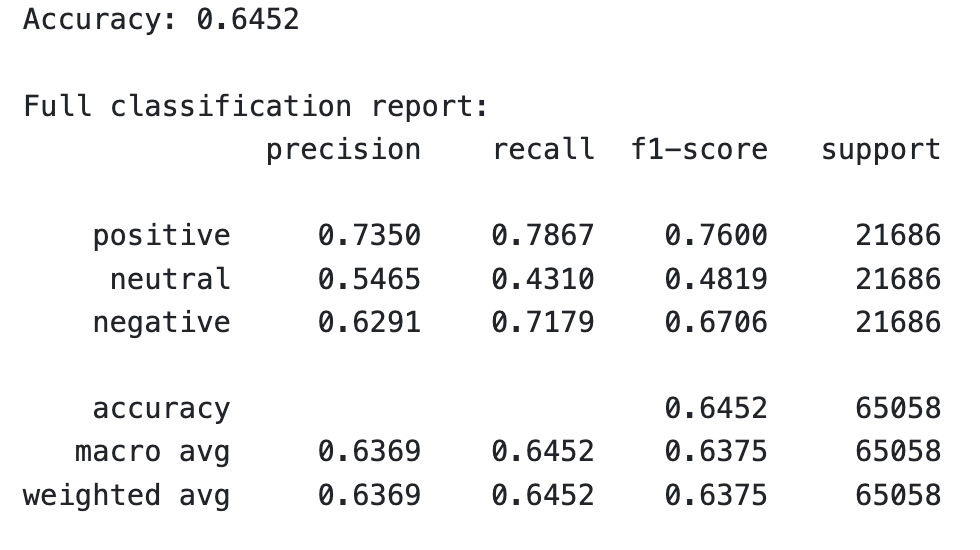

model_rubert_tiny

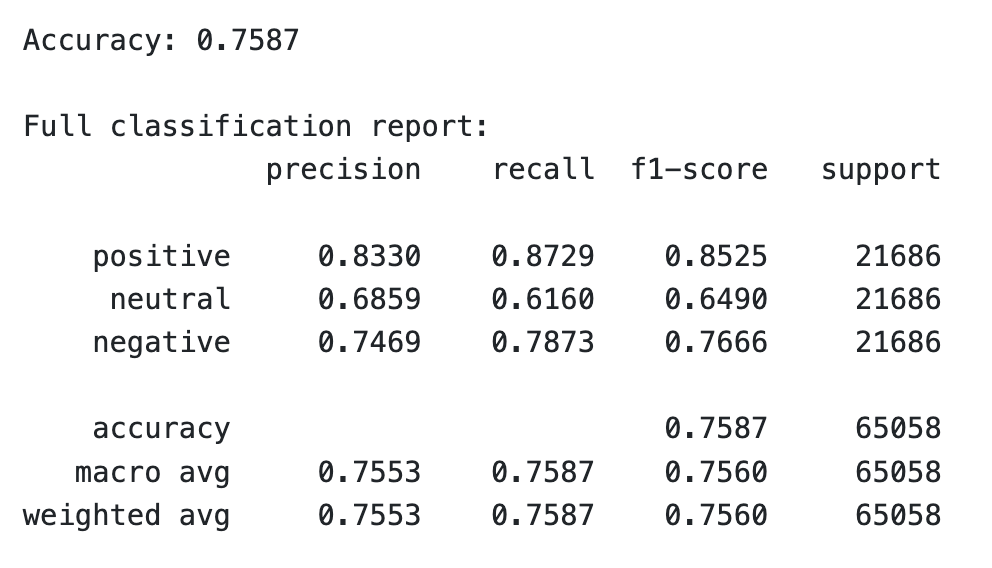

### Тоже тест модельки на данных отзывах о различных банках

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_colwidth') 

In [599]:
df_banks = pd.read_csv('datasets/final_review_dataset_extended.csv')
df_banks

,Unnamed: 0,bank,type,user_name,review_title,review,review_dttm,review_views,review_comments,rating_value,Вежливые сотрудники,Доступность и поддержка,Прозрачные условия,"Удобство приложения, сайта",review_len,review_len_in_tokens
0,1,Россельхозбанк,Person,user-430412136020,Открытие счета ИП,Добрый день! Я являюсь ИП и стоял перед выборо...,2023-05-02,773,0,5,3.0,3.0,3.0,3.0,171.0,363.0
1,2,Россельхозбанк,Person,user-60268947545,Спасибо за помощь,Здравствуйте! Достаточно давно являюсь клиенто...,2023-04-02,560,0,5,3.0,3.0,3.0,3.0,66.0,149.0
2,3,Банк ДОМ.РФ,Person,user-294212759595,Отличный сервис,"Здравствуйте,являюсь клиентом банка с ноября 2...",2023-03-02,737,1,5,3.0,3.0,3.0,3.0,70.0,164.0
3,4,Альфа-Банк,Person,user-841712733484,Блокировка денежных средств,14 января 2023 года была попытка перевода дене...,2023-01-02,627,3,1,NaN,NaN,NaN,NaN,170.0,337.0
4,5,Банк «Открытие»,Person,NaN,Хамство сотрудников Открытия,"У меня сложилось устойчивое впечатление, что в...",2023-01-02,517,31,1,1.0,1.0,1.0,1.0,106.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12387,12388,Совкомбанк,Person,user-882711916217,Скорая помощь,Здравствуйте.Хочу выразить свою благодарность ...,2022-11-11,969,2,5,3.0,3.0,3.0,3.0,184.0,347.0
12388,12389,Кредит Европа Банк,Person,user-86968728439,Прислали смс,Вчера моей маме тоже пришла смс от вашего имен...,2022-11-11,888,2,1,NaN,NaN,NaN,NaN,86.0,183.0
12389,12390,Совкомбанк,Person,user-915611915816,Акция 0-0-24 На товар дня! Не присылают промок...,"Покупали в рассрочку в Эльдорадо (ТЦ Водный), ...",2022-11-11,1058,3,1,2.0,2.0,2.0,2.0,127.0,276.0
12390,12391,ЮниКредит Банк,Person,user-60989234575,Прекрасное обслуживание в ДО Пятницкая,8 ноября я обратилась в ДО Пятницкая к сотрудн...,2022-10-11,1231,0,5,3.0,3.0,3.0,3.0,62.0,137.0


In [597]:
a = df_banks[df_banks['review_len_in_tokens'] >= 512]
a.count()

Unnamed: 0                    1868
bank                          1868
type                          1868
user_name                     1865
review_title                  1868
review                        1868
review_dttm                   1868
review_views                  1868
review_comments               1868
rating_value                  1868
Вежливые сотрудники           1716
Доступность и поддержка       1716
Прозрачные условия            1716
Удобство приложения, сайта    1716
review_len                    1868
review_len_in_tokens          1868
dtype: int64

In [374]:
df_banks['bank'].value_counts()

bank
Тинькофф Банк       1551
Совкомбанк          1501
ВТБ                 1275
Хоум Кредит Банк     978
Альфа-Банк           861
                    ... 
Икано Банк             1
РЕСО Кредит            1
РостФинанс             1
Челиндбанк             1
Банк Интеза            1
Name: count, Length: 86, dtype: int64

In [454]:
df_tink = df_banks[df_banks['bank'] == 'Тинькофф Банк']
df_tink = df_tink.reset_index(drop=True)
print(df_tink)

      Unnamed: 0           bank    type          user_name  \
0            116  Тинькофф Банк  Person  user-639512735506   
1            128  Тинькофф Банк  Person  user-243411758992   
2            136  Тинькофф Банк  Person  user-317212732619   
3            147  Тинькофф Банк  Person        user2480014   
4            148  Тинькофф Банк  Person   user-85669212695   
...          ...            ...     ...                ...   
1546       12354  Тинькофф Банк  Person  user-744011917964   
1547       12361  Тинькофф Банк  Person           Kirillfd   
1548       12381  Тинькофф Банк  Person  user-930511916364   
1549       12385  Тинькофф Банк  Person  user-100411747518   
1550       12387  Тинькофф Банк  Person  user-954510488326   

                                        review_title  \
0                                  Безопасность ноль   
1                                  Несут полный бред   
2             Полключение опции без согласия клиента   
3     Заблокировали средства пе

In [111]:
def model_predict (model_name,data):
    df = data.copy()
    # 3. Загружаем модель и создаём пайплайн
    checkpoint = model_name
    tokenizer  = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
    model      = AutoModelForSequenceClassification.from_pretrained(checkpoint)

    pipe = TextClassificationPipeline(
        model=model,
        tokenizer=tokenizer,
        return_all_scores=False,   # нужна только лучшая метка
        device=-1                  # CPU
    )
    # задаём размер батча отдельно
    batch_size = 32
    # 4. Делаем предсказания батчами с truncation
    preds = []
    for start in tqdm(range(0, len(df), batch_size)):
        texts = df["text"].iloc[start:start+batch_size].tolist()
        results = pipe(
            texts,
            truncation=True,
            batch_size=batch_size,
            max_length=512
        )
        preds.extend([r["label"] for r in results])

    df["pred_label"] = preds
    return df

def rating_to_label(rating):
    #На вход получает рейтинг(1-5) и преобразоввывает в классы(отрицательный, нейтральный, положительный)
    if rating < 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'
    
def data_to_df(
    df: pd.DataFrame,
    text_col: str,
    label_col: str
) -> pd.DataFrame:
    """
    Выбирает из исходного DataFrame две колонки и переименовывает
    их в 'text' и 'label', не меняя оригинал.
    """

    sub = df[[text_col, label_col]].copy()
    sub = sub.rename(columns={
        text_col: "text",
        label_col: "label"
    })
    return sub

def metrics(df: pd.DataFrame, name_model ) -> None:
    """
    Рассчитывает и выводит accuracy и полный отчет классификации для предсказаний.

    Параметры:
    -----------
    df : DataFrame
        Таблица с двумя обязательными колонками:
        - 'label'     : истинные метки (true labels)
        - 'pred_label': предсказанные моделью метки (predicted labels)
    name_model : str, optional
        Название модели для вывода в заголовке. Если None, заголовок не печатается.

    Возвращает:
    -----------
    None
        Результаты выводятся в консоль.
    """
    if name_model:
        print(f"=== Evaluation for {name_model} ===\n")

    # Истинные и предсказанные метки
    y_true = df["label"]
    y_pred = df["pred_label"]

    # 1) Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}\n")

    # 2) Полный отчет классификации
    report = classification_report(
        y_true,
        y_pred,
        labels=["positive", "neutral", "negative"],
        digits=4
    )
    print("Full classification report:")
    print(report)

def coding_label (df,name_model):
    if name_model == model_rubert_base:
        df['pred_label'] = df['pred_label'].str.lower()
    elif name_model == model_RuReviews:
        mapping = {
        "LABEL_0": "neutral",
        "LABEL_1": "negative",
        "LABEL_2": "positive"
        }
        df["pred_label"] = df["pred_label"].map(mapping)
    return df

#### F

In [442]:
df = df_banks.copy()

In [443]:
df['rating_value'] = df['rating_value'].apply(rating_to_label)
df = data_to_df(df=df,text_col='review',label_col='rating_value')
df

,text,label
0,Добрый день! Я являюсь ИП и стоял перед выборо...,positive
1,Здравствуйте! Достаточно давно являюсь клиенто...,positive
2,"Здравствуйте,являюсь клиентом банка с ноября 2...",positive
3,14 января 2023 года была попытка перевода дене...,negative
4,"У меня сложилось устойчивое впечатление, что в...",negative
...,...,...
12387,Здравствуйте.Хочу выразить свою благодарность ...,positive
12388,Вчера моей маме тоже пришла смс от вашего имен...,negative
12389,"Покупали в рассрочку в Эльдорадо (ТЦ Водный), ...",negative
12390,8 ноября я обратилась в ДО Пятницкая к сотрудн...,positive


In [444]:
df_neg = df[df['label'] == 'negative']
df_neu = df[df['label']== 'neutral']
df_pos = df[df['label']== 'positive']

n_min = min(len(df_pos), len(df_neu), len(df_neg))

# Random Undersampling
# Делаем ресэмплинг без возвращения downsample
df_pos_ds = resample(df_pos, replace=False, n_samples=n_min, random_state=42)
df_neu_ds = resample(df_neu, replace=False, n_samples=n_min, random_state=42)
df_neg_ds = resample(df_neg, replace=False, n_samples=n_min, random_state=42)

df_balanced = pd.concat([df_pos_ds, df_neu_ds, df_neg_ds]).sample(frac=1, random_state=42,).reset_index(drop=True)
df_balanced

,text,label
0,Являюсь зарплатным клиентом сбербанка. Пришло ...,negative
1,Открыл расчетный счет в банке по рекомендации ...,positive
2,Всем доброго времени суток! Сегодня 09.12.2022...,positive
3,Отличный банк! Работа банка мне очень нравитьс...,positive
4,31 декабря 2022 в 13 18 сделал заказ (30064785...,neutral
...,...,...
1186,Добрый день! 19.01.23 получила через курьера к...,negative
1187,Как не работало нормально приложение ВТБ онлай...,negative
1188,5.10.2022 года оформил карту. Карта активирова...,negative
1189,Давно пользуюсь кредитной картой 100 дней от А...,negative


In [445]:
names_models = [model_rubert_tiny, model_RuReviews, model_rubert_base]

In [467]:
df = df_balanced.copy()
# df['rating_value'] = df['rating_value'].apply(rating_to_label)
# df = data_to_df(df=df,text_col='review',label_col='rating_value')
# df
for name_model in names_models:
    df = df_balanced.copy()
    df = model_predict(model_name= name_model,data = df)
    df = coding_label(df=df,name_model= name_model)
    metrics(df= df, name_model= name_model)
    

Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2034/2034 [09:20<00:00,  3.63it/s]


=== Evaluation for cointegrated/rubert-tiny-sentiment-balanced ===

Accuracy: 0.6452

Full classification report:
              precision    recall  f1-score   support

    positive     0.7350    0.7867    0.7600     21686
     neutral     0.5465    0.4310    0.4819     21686
    negative     0.6291    0.7179    0.6706     21686

    accuracy                         0.6452     65058
   macro avg     0.6369    0.6452    0.6375     65058
weighted avg     0.6369    0.6452    0.6375     65058



Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2034/2034 [1:34:04<00:00,  2.78s/it]


=== Evaluation for sismetanin/rubert-ru-sentiment-RuReviews ===

Accuracy: 0.7587

Full classification report:
              precision    recall  f1-score   support

    positive     0.8330    0.8729    0.8525     21686
     neutral     0.6859    0.6160    0.6490     21686
    negative     0.7469    0.7873    0.7666     21686

    accuracy                         0.7587     65058
   macro avg     0.7553    0.7587    0.7560     65058
weighted avg     0.7553    0.7587    0.7560     65058



Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 2034/2034 [1:28:32<00:00,  2.61s/it]


=== Evaluation for blanchefort/rubert-base-cased-sentiment ===

Accuracy: 0.6559

Full classification report:
              precision    recall  f1-score   support

    positive     0.6597    0.8864    0.7564     21686
     neutral     0.6317    0.2803    0.3883     21686
    negative     0.6606    0.8011    0.7241     21686

    accuracy                         0.6559     65058
   macro avg     0.6507    0.6559    0.6230     65058
weighted avg     0.6507    0.6559    0.6230     65058



In [461]:
df_errors.to_csv("all_errors.csv", index=False)

In [414]:
metrics(df_t_tiny,name_model= model_RuReviews)

=== Evaluation for sismetanin/rubert-ru-sentiment-RuReviews ===

Accuracy: 0.6609

Full classification report:
              precision    recall  f1-score   support

    positive     0.9981    0.5243    0.6875       986
     neutral     0.0708    0.3191    0.1158        47
    negative     0.6005    0.9517    0.7364       518

    accuracy                         0.6609      1551
   macro avg     0.5564    0.5984    0.5132      1551
weighted avg     0.8372    0.6609    0.6865      1551



model_rubert_base
Accuracy: 0.7506

Full classification report:
              precision    recall  f1-score   support

    positive     0.9762    0.6362    0.7704      6246
     neutral     0.0587    0.1562    0.0853       397
    negative     0.7248    0.9158    0.8092      5749

    accuracy                         0.7506     12392
   macro avg     0.5865    0.5694    0.5550     12392
weighted avg     0.8302    0.7506    0.7664     12392


model_RuReviews
Accuracy: 0.7399

Full classification report:
              precision    recall  f1-score   support

    positive     0.9951    0.5810    0.7337      6246
     neutral     0.0535    0.1587    0.0800       397
    negative     0.7238    0.9527    0.8226      5749

    accuracy                         0.7399     12392
   macro avg     0.5908    0.5641    0.5454     12392
weighted avg     0.8391    0.7399    0.7540     12392

model_rubert_tiny
Accuracy: 0.4966

Full classification report:
              precision    recall  f1-score   support

    positive     0.9445    0.5175    0.6686      6246
     neutral     0.0426    0.5642    0.0791       397
    negative     0.7280    0.4693    0.5707      5749

    accuracy                         0.4966     12392
   macro avg     0.5717    0.5170    0.4395     12392
weighted avg     0.8152    0.4966    0.6043     12392

### Модель опрделена

model_RuReviews 

In [470]:
pd.reset_option('display.max_colwidth')

In [471]:
df_banks

,Unnamed: 0,bank,type,user_name,review_title,review,review_dttm,review_views,review_comments,rating_value,Вежливые сотрудники,Доступность и поддержка,Прозрачные условия,"Удобство приложения, сайта",review_len,review_len_in_tokens
0,1,Россельхозбанк,Person,user-430412136020,Открытие счета ИП,Добрый день! Я являюсь ИП и стоял перед выборо...,2023-05-02,773,0,5,3.0,3.0,3.0,3.0,171.0,363.0
1,2,Россельхозбанк,Person,user-60268947545,Спасибо за помощь,Здравствуйте! Достаточно давно являюсь клиенто...,2023-04-02,560,0,5,3.0,3.0,3.0,3.0,66.0,149.0
2,3,Банк ДОМ.РФ,Person,user-294212759595,Отличный сервис,"Здравствуйте,являюсь клиентом банка с ноября 2...",2023-03-02,737,1,5,3.0,3.0,3.0,3.0,70.0,164.0
3,4,Альфа-Банк,Person,user-841712733484,Блокировка денежных средств,14 января 2023 года была попытка перевода дене...,2023-01-02,627,3,1,NaN,NaN,NaN,NaN,170.0,337.0
4,5,Банк «Открытие»,Person,NaN,Хамство сотрудников Открытия,"У меня сложилось устойчивое впечатление, что в...",2023-01-02,517,31,1,1.0,1.0,1.0,1.0,106.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12387,12388,Совкомбанк,Person,user-882711916217,Скорая помощь,Здравствуйте.Хочу выразить свою благодарность ...,2022-11-11,969,2,5,3.0,3.0,3.0,3.0,184.0,347.0
12388,12389,Кредит Европа Банк,Person,user-86968728439,Прислали смс,Вчера моей маме тоже пришла смс от вашего имен...,2022-11-11,888,2,1,NaN,NaN,NaN,NaN,86.0,183.0
12389,12390,Совкомбанк,Person,user-915611915816,Акция 0-0-24 На товар дня! Не присылают промок...,"Покупали в рассрочку в Эльдорадо (ТЦ Водный), ...",2022-11-11,1058,3,1,2.0,2.0,2.0,2.0,127.0,276.0
12390,12391,ЮниКредит Банк,Person,user-60989234575,Прекрасное обслуживание в ДО Пятницкая,8 ноября я обратилась в ДО Пятницкая к сотрудн...,2022-10-11,1231,0,5,3.0,3.0,3.0,3.0,62.0,137.0


In [ ]:
df_ros = df_banks[df_banks['bank']== 'Россельхозбанк'].reset_index(drop=True)
df_ros['rating_value'] = df_ros['rating_value'].apply(rating_to_label)

df_ros  = data_to_df(df=df_ros,text_col='review',label_col='rating_value')

df_ros = model_predict(model_RuReviews,df_ros)
df_ros = coding_label(df_ros,model_RuReviews)
metrics(df= df_ros,name_model=model_RuReviews)

Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 27/27 [01:28<00:00,  3.28s/it]

=== Evaluation for sismetanin/rubert-ru-sentiment-RuReviews ===

Accuracy: 0.8685

Full classification report:
              precision    recall  f1-score   support

    positive     0.9985    0.8664    0.9278       756
     neutral     0.0000    0.0000    0.0000         7
    negative     0.6026    0.9479    0.7368        96

    accuracy                         0.8685       859
   macro avg     0.5337    0.6048    0.5549       859
weighted avg     0.9461    0.8685    0.8989       859



In [495]:
df = df_ros.copy()

In [496]:
checkpoint = model_RuReviews
tokenizer  = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)

# 1. Посчитаем для каждого отзыва реальное число токенов
#    (без усечения, чтобы знать, кто длиннее 512)
def count_tokens(text):
    return len(tokenizer(text, truncation=False)["input_ids"])

df["token_count"] = df["text"].map(count_tokens)

# 2. Отметим ошибки классификации
df["is_error"] = df["pred_label"] != df["label"]

# 3. Сколько всего ошибок?
total_errors = df["is_error"].sum()
print(f"Всего ошибок классификации: {total_errors}")

# 4. Сколько из этих ошибок приходится на тексты длиннее 512 токенов?
long_errors = df[(df["is_error"]) & (df["token_count"] > 512)]
num_long_errors = len(long_errors)
pct_long_errors = num_long_errors / total_errors * 100 if total_errors else 0

print(f"Ошибок на длинных (>512 токенов) отзывах: {num_long_errors} "
      f"({pct_long_errors:.1f}% от всех ошибок)")

# 5. Отдельный датасет со всеми ошибочными примерами
df_errors = df[df["is_error"]].copy()

# 6. (Опционально) Отдельный датасет только с длинными ошибками
df_long_errors = long_errors.copy()

Всего ошибок классификации: 113
Ошибок на длинных (>512 токенов) отзывах: 5 (4.4% от всех ошибок)


In [499]:
pd.set_option('display.max_colwidth', None)

In [500]:
df_long_errors

,text,label,pred_label,token_count,is_error
8,"30.12.2022 оформлял договор ипотеки. Менеджер банка запросила на сделку свидетельтсва о рождении детей продавца (путем споров убедил ,что это только для покупателя необходимо) пообещала разослать акредитованным старховым компаниям запрос на оценку стоимости страховки, но не сделала (сам занялся и нашел) сообщила, что в страховках она ни чего не понимает и пускай страховщики сами разбираются что нужно и не нужно оформлять при заключении ипотечного договора (сам со страховщиком разбирался, страховщик только запрашивал у нее документы) умудрилась сообщить ложную информацию страховщику о сумме кредитования, заметил это во время прочтения договора страхования, так как сумма оплаты была значительно больше планируемой - оказалось что менеджер выслала не ту сумму страховщику(завышенную). при этом говорила что отправляла верную(реальную) Когда оформляли акредитив, сперва продавец указал в реквизитах банк Тинь...ф, но после изменил на банк Россель....оз, что бы разом снять всю сумму было удобнее. Об этом менеджер была в курсе. В итоге акредитив быоформлен и продавец получил деньги всеравно на банк Тинь...ф (ну как же так? а менеджер удивилась, кодга я ей задал вопрос после раскрытия акредитива. она меня уверила, что в реквизитах был Россель...оз банк указан - а мы не проверили реквизиты акредитива, зря - в них указан банк Тинь...ф оказался - она снова накосячила) в конце сделки (а сделка была электронная) попросила тождественнность согласия супруги продавца в 17 10 30 декабря 2022г (!!!!! в 17 10, кодга все по записи нотариусы и уже закрываются). На наш вопрос, а почему вы не предупредили нас об необходимости наличия этого документа был ответ я думала у вас он есть! Хорошо что продавец опытный, быстро собрался и поехал искать нотариус - респект ему за это! В итоге нашел нотариус и сделал документ, и мы успели податься в Росреестр. На сделке мне не отдали мой экземпляр кредитного договора! Прошу менеджера прислать мне копию, так как нужно уже оплачивать очередной платеж по договору, - она пока что не может это сделать.... В отделении банка на Ленинском проспекте 125 менеджер сказала что нет туалета, не то что для клиентов банка, даже они сами ходят в кафе в подвал под помещением банка(!). По факту оказалось, что нет там ни какого кафе, в туалет ходили в пекарню в сосднем здании. (Менеджера не стали расстраивать, что кафе с туалетом там уже давно нет...) Сделку Росреестр зарегистрировал,права собственнности перешли. Но раскрытия акредитива мы ждали еще неделю! Якобы документы в банк не пришли. В чем тогда суть эл.регистрации?должно все быстро? Банк раскрывал акредитив дольше, чем Росреестр регистрировал.... Когда пришли в банк квитанции на оплату рег.действий,пришлось забирать из отделения распечатку, и самое главное, на оплату было почему-то всего несколько часов(!!) в рабочее время. Почему-то часть документов на подпись ЭЦП понадобилось подписать 12 января 2023. И документы просто появились в приложении для подписания без уведомления и исчезли, так как прошел срок. Менеджер звонит 12 числа, что документы не подписали во время- эл.сделка отменяется, нужно заново подоваться в бумажном виде в МФЦ(!).Но,буквально через пару минут перезванивает и сообщает,что документы вновь загружены в приложение и их нужно срочно подписать. Возможно, это предновогодний ажиотаж ее так вымотал, но после НГ праздников сюрпризы же продолжились.... В итоге, сейчас я без кредитного договора, с подходящим по сроку уплаты первым платежем, который я не могу оплатить, так как менеджер банка мне не может прислать даже копию договора с реквизитами для оплаты.",positive,negative,806,True
170,"Итак... Решил воспользоваться кредитными каникулами с названием легкие каникулы , которые, как указано в описании на сайте банка, доступны всем клиентам без просроченной задолженности и не требуют предоставления документов о снижении дохода. Через виртуального помощника в чате банка выяснил, что необходим личный визит в отделение банк

### Пострение временных рядов датасеты с вб

In [ ]:
# Загружаем и создаём DataFrame
with open("datasets/airpods2.json", encoding="utf-8") as f:
    data = json.load(f)

reviews = data.get("reviews", [])

# 3. Собрать DataFrame из этого списка
df = pd.json_normalize(reviews)

# 4. Оставить только нужные колонки и назвать их по‑человечески
df = df.rename(columns={"text": "text", "date": "date"})
df = df[["text", "date"]]
df

,text,date
0,Достоинства:Отличные наушники,"Сегодня, 10:21"
1,Достоинства:Заводская упаковка в плёнке и проработали полчаса сразу после вскрытия упаковки. Сегодня зарядились на 100 % и подключились ок.Недостатки:Правый наушники разрядился быстрее левого(Комментарий:Покупала по рекомендации коллеги,"Сегодня, 10:09"
2,"Достоинства:Очень быстрая тех. подержка, хороший звук, всё работает.Комментарий:Спасибо🫶🏻","Сегодня, 08:54"
3,Взял забрал. Посидел чуть чуть и они начали моросить. Сами по себе то включались то нет. И в итоге выключились и не включается. Когда пытаюсь подключиться то мигает красным хотя я ставил из на зарядку на долго. Короче товар полный отстой,"Сегодня, 00:42"
4,"Достоинства:Подключаются, как оригинал, сразу после открытия кейса.Комментарий:Сегодня первый день как пользовалась, вроде ничего, музыка играет.)","Сегодня, 00:22"
...,...,...
924,Достоинства:Всё отлично работаетНедостатки:Минусов не обнаружилКомментарий:Товаром доволен. Всё соответствует заявленным характеристикам.,"16 мая, 16:30"
925,"Достоинства:удобствоНедостатки:ЗвукКомментарий:Если вам важен звук, тогда не берите. Пришлось поиграть с эквалайзером чтобы хоть как то исправить ситуацию. А так бассов 0. если их не убирать, то они как будто глушат голос исполнителя, будто ты в бочке. А так они удобные и не особо дорогие.","16 мая, 16:03"
926,ребята поставляют наушники хорошего качестваПервоначальный отзыв,"16 мая, 15:18 • Дополнен"
927,"Достоинства:Качество наушников, цена!Недостатки:Звук👎Комментарий:По качеству наушники топ, но звук оставляет желать лучшего, имеются ориганал первых airpods звук в разы лучше, но для повседневки сойдет. Посмотрим на сколько их хватит.","16 мая, 13:27"


In [44]:
df1 = df.copy()

In [ ]:
# 1) Словарь русских падежных месяцев в номер
MONTHS = {
    "января":   1, "февраля":  2, "марта":    3,
    "апреля":   4, "мая":       5, "июня":     6,
    "июля":     7, "августа":   8, "сентября": 9,
    "октября": 10, "ноября":   11, "декабря": 12,
}

def parse_date_manual(s, default_year=None):
    """
    Парсит строки вида:
      - '14 мая, 14:03'
      - '02 марта 2024, 17:28'
      - 'Сегодня, 14:03'
      - 'Вчера, 08:11'
      - None, '' → возвращает pd.NaT
    Без сторонних библиотек.
    """
    # Обрабатываем None и нестроковые значения
    if s is None or not isinstance(s, str):
        return pd.NaT

    s = s.strip()
    if not s:
        return pd.NaT

    today = datetime.now().date()
    lower = s.lower()
    # Обработка 'Сегодня' и 'Вчера'
    if lower.startswith('сегодня'):
        return pd.Timestamp(today)
    if lower.startswith('вчера'):
        return pd.Timestamp(today - timedelta(days=1))

    # Оставляем только часть до запятой или до '·' (отбрасываем время и 'Дополнен')
    # разделяем по запятой или по символу '·'
    part = re.split(r"[,··]", s, 1)[0].strip()

    # Ищем год внутри строки
    m = re.search(r"(20\d{2})", part)
    if m:
        year = int(m.group(1))
        part = part.replace(m.group(1), '').strip()
    else:
        year = default_year or today.year

    # Разбираем день и месяц
    try:
        day_str, mon_str = part.split()
        day = int(day_str)
        month = MONTHS[mon_str.lower()]
    except Exception:
        return pd.NaT

    # Составляем и возвращаем объект datetime
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return pd.NaT
# --- Применяем к DataFrame ---

# Предполагаем, что df уже загружен и df['date'] — объект-строка
df1['date_parsed'] = df1['date'].apply(lambda x: parse_date_manual(x))

# # Фильтруем только с мая (месяц >= 5)
# df = df[df['date_parsed'].dt.month >= 5].reset_index(drop=True)

# # Если старый столбец больше не нужен
# df = df.drop(columns=['date'])

# # Переименуем для удобства
# df = df.rename(columns={'date_parsed': 'date'})

df1


,text,date,date_parsed
0,Достоинства:Отличные наушники,"Сегодня, 10:21",2025-07-24
1,Достоинства:Заводская упаковка в плёнке и проработали полчаса сразу после вскрытия упаковки. Сегодня зарядились на 100 % и подключились ок.Недостатки:Правый наушники разрядился быстрее левого(Комментарий:Покупала по рекомендации коллеги,"Сегодня, 10:09",2025-07-24
2,"Достоинства:Очень быстрая тех. подержка, хороший звук, всё работает.Комментарий:Спасибо🫶🏻","Сегодня, 08:54",2025-07-24
3,Взял забрал. Посидел чуть чуть и они начали моросить. Сами по себе то включались то нет. И в итоге выключились и не включается. Когда пытаюсь подключиться то мигает красным хотя я ставил из на зарядку на долго. Короче товар полный отстой,"Сегодня, 00:42",2025-07-24
4,"Достоинства:Подключаются, как оригинал, сразу после открытия кейса.Комментарий:Сегодня первый день как пользовалась, вроде ничего, музыка играет.)","Сегодня, 00:22",2025-07-24
...,...,...,...
924,Достоинства:Всё отлично работаетНедостатки:Минусов не обнаружилКомментарий:Товаром доволен. Всё соответствует заявленным характеристикам.,"16 мая, 16:30",2025-05-16
925,"Достоинства:удобствоНедостатки:ЗвукКомментарий:Если вам важен звук, тогда не берите. Пришлось поиграть с эквалайзером чтобы хоть как то исправить ситуацию. А так бассов 0. если их не убирать, то они как будто глушат голос исполнителя, будто ты в бочке. А так они удобные и не особо дорогие.","16 мая, 16:03",2025-05-16
926,ребята поставляют наушники хорошего качестваПервоначальный отзыв,"16 мая, 15:18 • Дополнен",2025-05-16
927,"Достоинства:Качество наушников, цена!Недостатки:Звук👎Комментарий:По качеству наушники топ, но звук оставляет желать лучшего, имеются ориганал первых airpods звук в разы лучше, но для повседневки сойдет. Посмотрим на сколько их хватит.","16 мая, 13:27",2025-05-16


In [ ]:
checkpoint = "sismetanin/rubert-ru-sentiment-RuReviews"
df = df1.copy()
# 3. Загружаем модель и создаём пайплайн
tokenizer  = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
model      = AutoModelForSequenceClassification.from_pretrained(checkpoint)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # нужна только лучшая метка
    device=-1                  # CPU
)
# задаём размер батча отдельно
batch_size = 32
# 4. Делаем предсказания батчами с truncation
    
pred_labels = []
pos_probs = []
neg_probs = []

for start in tqdm(range(0, len(df), batch_size)):
    texts = df["text"].iloc[start:start+batch_size].tolist()
    results = pipe(
        texts,
        truncation=True,
        max_length=512,
        batch_size=batch_size
    )
    for scores in results:
        # scores — список словарей [{'label':'positive','score':...}, ...]
        # Выбираем лучшую метку
        best_label = max(scores, key=lambda x: x["score"])["label"]
        pred_labels.append(best_label)
        # Собираем вероятности positive и negative
        prob_map = {item["label"]: item["score"] for item in scores}
        pos_probs.append(prob_map.get("LABEL_2", 0.0))
        neg_probs.append(prob_map.get("LABEL_1", 0.0))

# Добавляем колонки в DataFrame
df["pred_label"] = pred_labels
df["p_positive"] = pos_probs
df["p_negative"] = neg_probs

mapping = {
        "LABEL_0": "neutral",
        "LABEL_1": "negative",
        "LABEL_2": "positive"
        }
df["pred_label"] = df["pred_label"].map(mapping)
pd.set_option('display.max_colwidth', None)
df.head(40)

Device set to use cpu
/Users/mishnya/Documents/vs code project/Webbee_internship/.venv/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


In [54]:
print(df['date_parsed'].value_counts())
n_days = df['date_parsed'].nunique()
print(f"В df_new есть отзывы всего за {n_days} дней")

date_parsed
2025-06-10    27
2025-06-04    26
2025-06-01    25
2025-06-12    23
2025-06-11    23
              ..
2025-07-24     5
2025-06-20     3
2025-07-05     3
2025-07-06     3
2025-07-07     3
Name: count, Length: 70, dtype: int64
В df_new есть отзывы всего за 70 дней


In [57]:
df = df.drop(columns=['date'])

# # Переименуем для удобства
df = df.rename(columns={'date_parsed': 'date'})

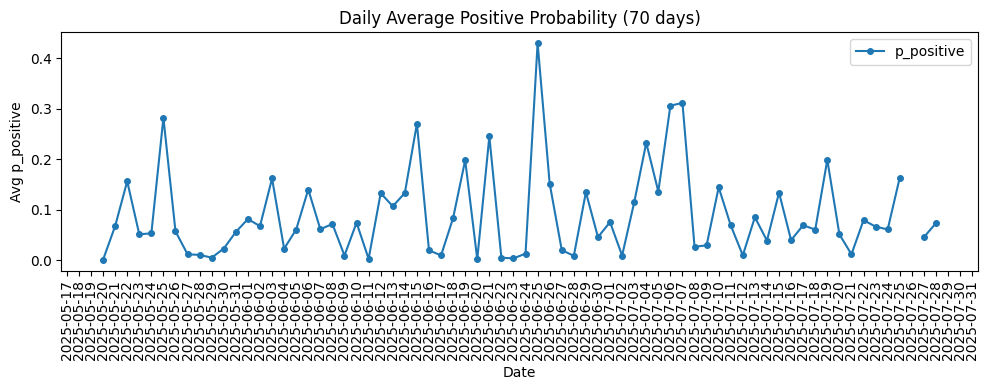

In [ ]:
# 1. Убедимся, что date_parsed — datetime64
df['date'] = pd.to_datetime(df['date'])

# 2. Собираем суточный ряд (avg p_positive)
ts = (
    df
    .set_index('date')['p_negative']
    .resample('D').mean()      # один день — одна точка (NaN, если нет отзывов)
)

# 3. (По желанию) заполнить пропуски, например, вперёд
# ts = ts.fillna(method='ffill')

# 4. Сброс индекса для удобства
ts = ts.reset_index(name='avg_p_positive')

# 5. Построим с маркерами и тиками на каждый день
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts['date'], ts['avg_p_positive'],
        marker='o', linestyle='-',
        markersize=4, label='p_positive')

# Настроим тики по каждому дню:
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))        # тики через 1 день
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # формат YYYY‑MM‑DD

plt.title('Daily Average Positive Probability (70 days)')
plt.xlabel('Date')
plt.ylabel('Avg p_positive')
plt.xticks(rotation=90)  # чтобы все подписи поместились
plt.tight_layout()
plt.legend()
plt.show()


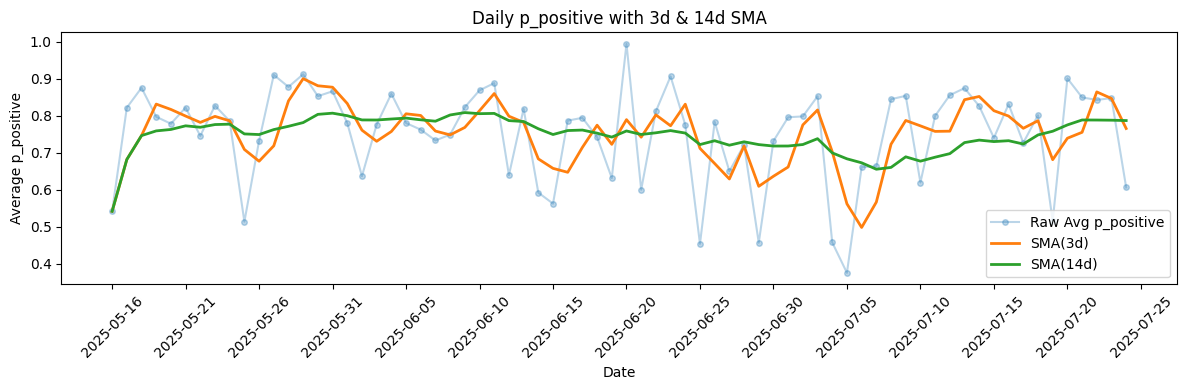

In [81]:
# 2. Делаем ресемплинг по дням и вычисляем среднее p_positive
ts = (
    df
    .set_index('date')['p_positive']
    .resample('D')    # одна точка на каждый день
    .mean()           # среднее p_positive в дне (NaN, если нет отзывов)
    .reset_index(name='avg_p_positive')
)

# 3. Считаем скользящие средние
ts['sma3']  = ts['avg_p_positive'].rolling(window=3,  min_periods=1).mean()
ts['sma14'] = ts['avg_p_positive'].rolling(window=14, min_periods=1).mean()

# 4. Строим график со всеми необходимыми настройками
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ts['date'], ts['avg_p_positive'],
        marker='o', linestyle='-', markersize=4,
        alpha=0.3, label='Raw Avg p_positive')

ax.plot(ts['date'], ts['sma3'],
        linewidth=2, label='SMA(3d)')

ax.plot(ts['date'], ts['sma14'],
        linewidth=2, label='SMA(14d)')

# Настройка тиков по дням
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))   # каждый пятый день
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Daily p_positive with 3d & 14d SMA')
plt.xlabel('Date')
plt.ylabel('Average p_positive')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# --- 1. Собираем суточную сводку ---
df_daily = (
    df
    .set_index('date')
    .resample('D')
    .agg(
        n_total=('text', 'count'),
        n_neg=('p_negative', 'sum')
    )
)
df_daily = df_daily[df_daily['n_total'] > 0]
df_daily['p_neg'] = df_daily['n_neg'] / df_daily['n_total']

# --- 2. Фоновый уровень (медиана) ---
mu0 = df_daily['p_neg'].median()

# --- 3. Wilson CI (99%) ---
ci_low99, ci_upp99 = proportion_confint(
    count=df_daily['n_neg'].astype(int).values,
    nobs=df_daily['n_total'].astype(int).values,
    alpha=0.01,
    method='wilson'
)
df_daily['ci_low99'] = ci_low99
df_daily['ci_upp99'] = ci_upp99

# --- 4. Биномиальный тест (односторонний) ---
def one_sided_binom_test(row):
    k = int(row['n_neg'])
    n = int(row['n_total'])
    return binomtest(k, n=n, p=mu0, alternative='greater').pvalue

df_daily['p_val'] = df_daily.apply(one_sided_binom_test, axis=1)

# --- 5. Отбор аномальных дней ---
anoms_wilson = df_daily[df_daily['ci_low99'] > mu0]
anoms_binom  = df_daily[df_daily['p_val'] < 0.05]

# Выводим результаты
print("=== Аномалии по Wilson CI (99%) ===")
print(anoms_wilson[['n_total','n_neg','p_neg','ci_low99','ci_upp99']])

print("\n=== Аномалии по Binomial Test (p < 0.05) ===")
print(anoms_binom[['n_total','n_neg','p_neg','p_val']])


=== Аномалии по Wilson CI (99%) ===
            n_total     n_neg     p_neg  ci_low99  ci_upp99
date                                                       
2025-06-15       12  3.255733  0.271311  0.065732  0.612292

=== Аномалии по Binomial Test (p < 0.05) ===
            n_total     n_neg     p_neg     p_val
date                                             
2025-06-15       12  3.255733  0.271311  0.014208


In [79]:
df[df['date']== '2025-06-15']

,text,date,pred_label,p_positive,p_negative
425,"Достоинства:Просто бомба пушка, это просто невероятно, 1:1 как оригинал 🤩",2025-06-15,positive,0.997016,0.001122
426,Достоинства:Пришло вовремя,2025-06-15,positive,0.545726,0.008240
427,"не разочаровалась в покупке этих наушников, к покупке рекомендую👍Первоначальный отзыв",2025-06-15,neutral,0.178606,0.253955
428,Не пожклкл что взял именно эти наушникиПервоначальный отзыв,2025-06-15,negative,0.001708,0.984874
429,"Достоинства:Ни чегоНедостатки:Товар китай паленый хуже китая даже, левый наушник отвалился через 2 недели пользования, шумадав вообще полная фигня эти все функции не работают от слова совсем они просто есть и не болееКомментарий:Не советую товар вообще 500 рублей еиу цена",2025-06-15,negative,0.000381,0.992152
430,"Достоинства:приятные на ощупь, звук чистый и громкий, микрофон кстати тоже отличныйКомментарий:пользоваться можно в общем и целом)",2025-06-15,positive,0.994088,0.000796
431,"Достоинства:хороший звук, отличное качествоНедостатки:все отличноКомментарий:лучший товар на рынке за свои деньги, беру не первый раз, качество на высоте!",2025-06-15,positive,0.996940,0.001368
432,"Достоинства:Хорошие наушники, чехол для наушников в подарок, звук чёткий, при включении музыка, при зарядке музыка, запасные амбушюры есть.",2025-06-15,positive,0.997298,0.001130
433,"Достоинства:Очень хороший звук, очень удобные. Маленькие стильные.Обажаю их.Недостатки:Один не достаток, медленно заряжаеться. И вообще показывает, что нет зарядки",2025-06-15,positive,0.542010,0.010061
434,"Недостатки:Все!Комментарий:Какой кошмар! Я не могу вернуть наушники по браку, т.к сразу выкинула коробку, пока шла домой. Дома подключила уже. Они теряют соединение постоянно( Я даже выключила блютуз, они у меня в ушах были. И начали пиликать, туда сюда. Типа подключаются и отключаются. К чему они подключаются, раз сети нет? Перезагружала их. Ничего.Я не могу ими пользоваться увы. Очень жаль, потраченные деньги. Не 300 р все же стоят.",2025-06-15,negative,0.000490,0.991506


In [101]:
checkpoint = model_RuReviews
tokenizer  = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
model      = AutoModelForSequenceClassification.from_pretrained(checkpoint)
text = "Достоинства:Как оригинал Недостатки:Нету Комментарий:Очень понравились"
# 1) Все метки с вероятностями
res_all = pipe(text, truncation=True, max_length=512)
print(res_all)  
# [{'label':'negative','score':0.95}, {'label':'neutral','score':0.04}, {...}]

# 2) Только топ‑1
pipe_top1 = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=False,  # top_k=1
    device=-1
)
res = pipe_top1(text, truncation=True, max_length=512)
label = res[0]['label']
score = res[0]['score']
print(f"Predicted: {label} (score={score:.2f})")


Device set to use cpu


[[{'label': 'LABEL_0', 'score': 0.6735327243804932}, {'label': 'LABEL_1', 'score': 0.023785235360264778}, {'label': 'LABEL_2', 'score': 0.3026820421218872}]]
Predicted: LABEL_0 (score=0.67)


### Работа с отзывами о наушниках( можно сразу смотреть от сюда)

In [220]:
df = pd.read_excel('datasets/pods.xlsx')
df = df[df['review_date'] != 'Не найдено']
# Убераем из отзыва коментраии вроде "Недостатков нет", т.к. модель реаиграет на такое отрицательно и отзыв становиться нейтральным
EMPTY_CONS = [
    r'^нет$',  
    r'^нету$',
    r'^-+$',
    r'^(?:нет(?:у)?\s+минусов?)$',
    r'^(?:все|всё)\s+(?:ок|отлично)$',
    r'^ничего$',
    r'^без\s+минус(?:ов)?$',
    r'^минус(?:ов|ы)?\s+нет(?:у)?$',
    r'^^не\s+(?:наш[её]л|нашл[аи])$',
    r'^не\s+встретил[аи]$',
    r'^ещ[её]\s+не\s+нашл[аи]$',
    r'^(?:недостатков|минус(?:ов)?)\s+пока\s+не\s+увидел[аи]$',
    r'^минус(?:ы)?\s+ещ[её]\s+не\s+нашл[аи]$',
]
EMPTY_CONS_RE = re.compile(r'^(?:' + r'|'.join(EMPTY_CONS) + r')$', flags=re.IGNORECASE)

def clean_disadvantages(text: str) -> str:
    """
    Если text полностью совпадает с одним из шаблонов EMPTY_CONS,
    возвращаем np.nan, иначе — оригинальный текст.
    """
    if not isinstance(text, str):
        return np.nan
    t = text.strip()
    if EMPTY_CONS_RE.match(t):
        return np.nan
    return t

# Применяем
df['cons_clean'] = df['disadvantages'].apply(clean_disadvantages)

df[df['cons_clean'].isna() == False].head(5)

,product_id,product_name,reviewer,rating,review_date,advantages,disadvantages,comment,purchase_state,cons_clean
1,218295861,Наушники беспроводные NEW AirPods 4 ANC для iPhone и Android,Владислав,5,"Сегодня, 10:46","Отличные наушники за свои деньги. Качество звука на высоте, все работает хорошо. Удобно сидят в ушах, не выпадают даже при активном движении. Баса достаточно, звук чистый и детализированный. Автономность радует – хватает на несколько часов даже с активным ANC. Корпус аккуратный, сборка надежная. За такие деньги – отличный выбор. Рекомендую!",Не выявлено.,NaN,Выкупили,Не выявлено.
2,218295861,Наушники беспроводные NEW AirPods 4 ANC для iPhone и Android,Мухаммад,1,"Сегодня, 10:29",Не че не понравилось,В фотографиях другие совсем нашники а отправили вообще другие наушники порванная упаковка,Деньги на ветер,Выкупили,В фотографиях другие совсем нашники а отправили вообще другие наушники порванная упаковка
5,218295861,Наушники беспроводные NEW AirPods 4 ANC для iPhone и Android,Дарья,1,"Сегодня, 00:13",NaN,Не держат заряд \nДеньги на ветер...,NaN,Выкупили,Не держат заряд \nДеньги на ветер...
13,218295861,Наушники беспроводные NEW AirPods 4 ANC для iPhone и Android,Дарья,4,"Вчера, 12:41","хорошие наушники , приехали полностью заряженные и держали зарядку долго","при подключении к телефону , всегда высвечивается, что на левом наушнике 4 процента",NaN,Выкупили,"при подключении к телефону , всегда высвечивается, что на левом наушнике 4 процента"
14,218295861,Наушники беспроводные NEW AirPods 4 ANC для iPhone и Android,Илья,4,"Вчера, 09:36",Хорошие наушники,"Иногда илет рассинхрон, и такое чустао что говорят где то с зажи тебя",NaN,Выкупили,"Иногда илет рассинхрон, и такое чустао что говорят где то с зажи тебя"


In [221]:
def compose_text(row):
    # Собираем из коллонок(advantages,disadvantages,comment) полноценный отзыв
    parts = []
    # Сначала комментарий
    comm = row.get('comment')
    if isinstance(comm, str) and comm.strip():
        parts.append(comm.strip())
    # Затем преимущества
    adv = row.get('advantages')
    if isinstance(adv, str) and adv.strip():
        parts.append(f"{adv.strip()}") # f"Достоинства:
    # И, наконец, реальные недостатки
    cons = row.get('cons_clean')
    if isinstance(cons, str) and cons.strip():
        parts.append(f"{cons.strip()}") # f"Недостатки:
    return '. '.join(parts)

df['text'] = df.apply(compose_text, axis=1)

df_final = df[['text', 'review_date', 'rating']].copy().reset_index(drop=True)
df_final = df_final.rename(columns={"review_date": "date"})
df_final.head()

,text,date,rating
0,"Отличные наушники за свои деньги. Качество звука на высоте, все работает хорошо. Удобно сидят в ушах, не выпадают даже при активном движении. Баса достаточно, звук чистый и детализированный. Автономность радует – хватает на несколько часов даже с активным ANC. Корпус аккуратный, сборка надежная. За такие деньги – отличный выбор. Рекомендую!. Не выявлено.","Сегодня, 10:46",5
1,Деньги на ветер. Не че не понравилось. В фотографиях другие совсем нашники а отправили вообще другие наушники порванная упаковка,"Сегодня, 10:29",1
2,за свою цену наушники отличные,"Сегодня, 07:16",5
3,"Были не большие проблемы, служба поддежки помогли решить , очень хпрофессионально и быстро! Спасибо!","Сегодня, 06:15 • Дополнен",5
4,Не держат заряд \nДеньги на ветер...,"Сегодня, 00:13",1


In [224]:
# 1) Словарь русских падежных месяцев в номер
MONTHS = {
    "января":   1, "февраля":  2, "марта":    3,
    "апреля":   4, "мая":       5, "июня":     6,
    "июля":     7, "августа":   8, "сентября": 9,
    "октября": 10, "ноября":   11, "декабря": 12,
}

def parse_date_manual(s, default_year=None):
    """
    Парсит строки вида:
      - '14 мая, 14:03'
      - '02 марта 2024, 17:28'
      - 'Сегодня, 14:03'
      - 'Вчера, 08:11'
      - None, '' → возвращает pd.NaT
    Без сторонних библиотек.
    """
    # Обрабатываем None и нестроковые значения
    if s is None or not isinstance(s, str):
        return pd.NaT

    s = s.strip()
    if not s:
        return pd.NaT

    today = datetime.now().date()
    lower = s.lower()
    # Обработка 'Сегодня' и 'Вчера'
    if lower.startswith('сегодня'):
        return pd.Timestamp(today)
    if lower.startswith('вчера'):
        return pd.Timestamp(today - timedelta(days=1))

    # Оставляем только часть до запятой или до '·' (отбрасываем время и 'Дополнен')
    part = re.split(r"[,··]", s, 1)[0].strip()

    # Ищем год внутри строки
    m = re.search(r"(20\d{2})", part)
    if m:
        year = int(m.group(1))
        part = part.replace(m.group(1), '').strip()
    else:
        year = default_year or today.year

    # Разбираем день и месяц
    try:
        day_str, mon_str = part.split()
        day = int(day_str)
        month = MONTHS[mon_str.lower()]
    except Exception:
        return pd.NaT

    # Составляем и возвращаем объект datetime
    try:
        return pd.Timestamp(year=year, month=month, day=day)
    except ValueError:
        return pd.NaT

df1 = df_final.copy()
# Предполагаем, что df уже загружен и df['date'] — объект-строка
df1['date_parsed'] = df1['date'].apply(lambda x: parse_date_manual(x))

# Фильтруем только с мая (месяц >= 5)
df1 = df1[(df1["date_parsed"].dt.year >= 2025) &(df1["date_parsed"].dt.month >= 5)].reset_index(drop=True)
# Если старый столбец больше не нужен
df1 = df1.drop(columns=['date'])

# Переименуем для удобства
df1 = df1.rename(columns={'date_parsed': 'date'})


In [226]:

df = df1.copy()

pred_labels = []
pos_probs = []
neg_probs = []

for start in tqdm(range(0, len(df), batch_size)):
    texts = df["text"].iloc[start:start+batch_size].tolist()
    results = pipe(
        texts,
        truncation=True,
        max_length=512,
        batch_size=batch_size
    )
    for scores in results:
        # scores — список словарей [{'label':'positive','score':...}, ...]
        # Выбираем лучшую метку
        best_label = max(scores, key=lambda x: x["score"])["label"]
        pred_labels.append(best_label)
        # Собираем вероятности positive и negative
        prob_map = {item["label"]: item["score"] for item in scores}
        pos_probs.append(prob_map.get("LABEL_2", 0.0))
        neg_probs.append(prob_map.get("LABEL_1", 0.0))

# Добавляем колонки в DataFrame
df["pred_label"] = pred_labels
df["p_positive"] = pos_probs
df["p_negative"] = neg_probs

mapping = {
        "LABEL_0": "neutral",
        "LABEL_1": "negative",
        "LABEL_2": "positive"
        }
df["pred_label"] = df["pred_label"].map(mapping)
pd.set_option('display.max_colwidth', None)


100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


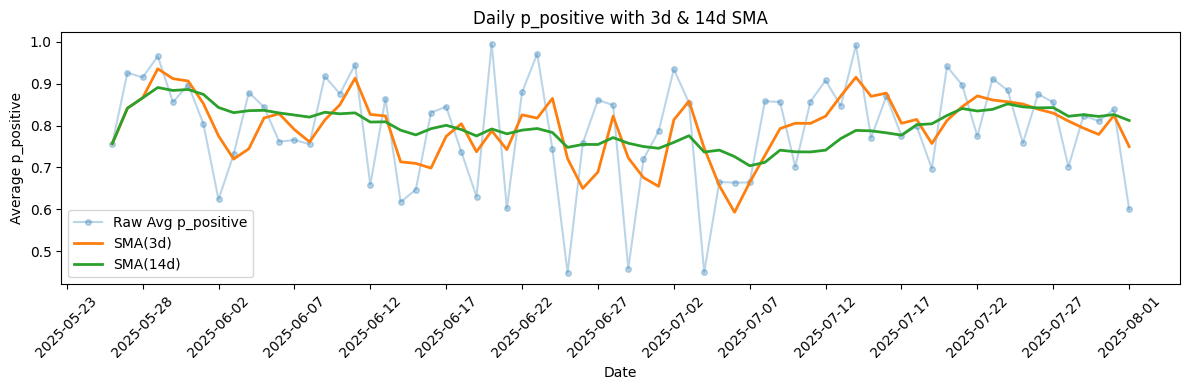

In [227]:
# 2. Делаем ресемплинг по дням и вычисляем среднее p_positive
ts = (
    df
    .set_index('date')['p_positive']
    .resample('D')    # одна точка на каждый день
    .mean()           # среднее p_positive в дне (NaN, если нет отзывов)
    .reset_index(name='avg_p_positive')
)

# 3. Считаем скользящие средние
ts['sma3']  = ts['avg_p_positive'].rolling(window=3,  min_periods=1).mean()
ts['sma14'] = ts['avg_p_positive'].rolling(window=14, min_periods=1).mean()

# 4. Строим график со всеми необходимыми настройками
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ts['date'], ts['avg_p_positive'],
        marker='o', linestyle='-', markersize=4,
        alpha=0.3, label='Raw Avg p_positive')

ax.plot(ts['date'], ts['sma3'],
        linewidth=2, label='SMA(3d)')

ax.plot(ts['date'], ts['sma14'],
        linewidth=2, label='SMA(14d)')

# Настройка тиков по дням
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))   # каждый пятый день
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Daily p_positive with 3d & 14d SMA')
plt.xlabel('Date')
plt.ylabel('Average p_positive')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

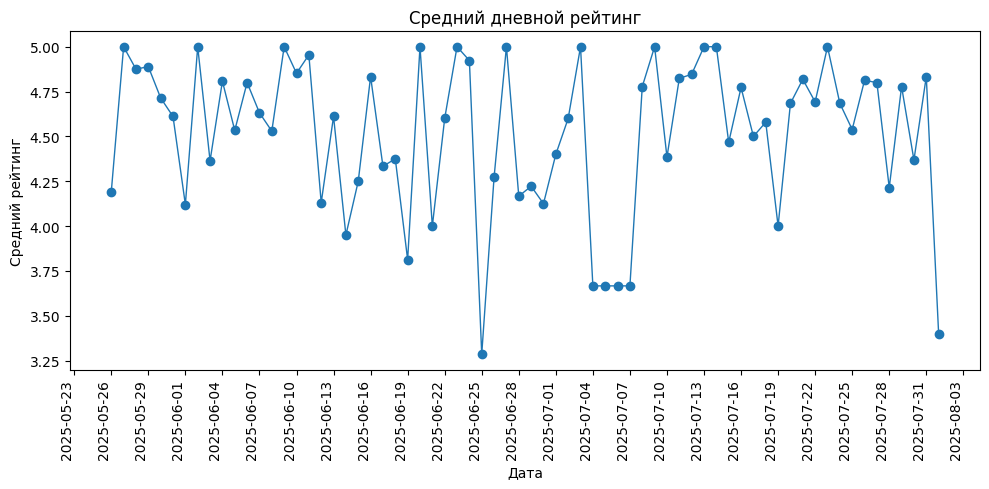

In [228]:
# Считаем средний дневной рейтинг
daily_avg = df.groupby('date')['rating'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(daily_avg['date'], daily_avg['rating'], marker='o', linewidth=1)

# формат отображения дат
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# метки через каждый 3 дня
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))

fig.autofmt_xdate()  # подкручивает поворот и отступы для дат
ax.set_title("Средний дневной рейтинг")
ax.set_xlabel("Дата")
ax.set_ylabel("Средний рейтинг")
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


In [235]:
a = df[df['date']== '2025-07-06']
a['rating'].mean()
display(a)

,text,rating,date,pred_label,p_positive,p_negative
395,"Сначала не разобрался,продавец помог и все внятно рассказал .Я доволен наушниками ,звук прекрасный!",5,2025-07-06,positive,0.994206,0.001109
396,Все отлично работает,5,2025-07-06,positive,0.995894,0.002031
397,"При смене амбишур, одна из них порвалась и осталась жесткая часть, которую очень тяжело снять, плюс при каждом подключении вылезает анимация на телефоне. Ничего. Огромные",1,2025-07-06,negative,0.000828,0.914532


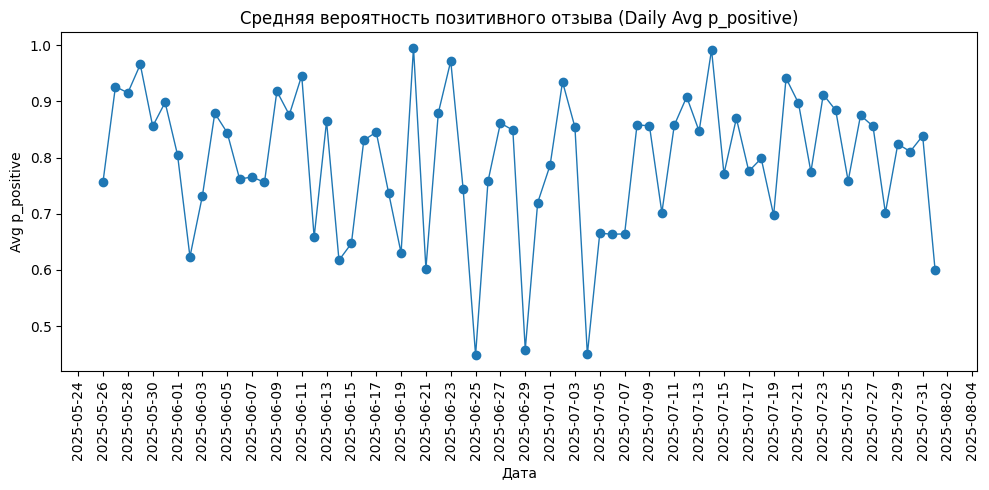

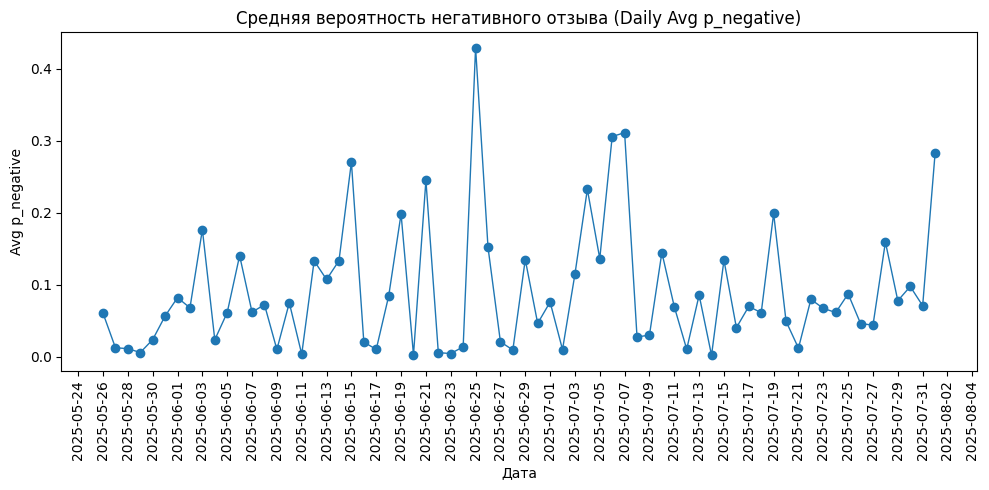

In [233]:
# Группируем по дате и вычисляем средние вероятности
daily_probs = df.groupby('date')[['p_positive', 'p_negative']].mean().reset_index()

# Функция для настройки общих параметров графика
def plot_daily_prob(date, values, title, ylabel):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(date, values, marker='o', linewidth=1)
    ax.set_title(title)
    ax.set_xlabel("Дата")
    ax.set_ylabel(ylabel)
    # Форматирование дат на оси X
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))  # метки каждые 2 дня
    ax.tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()

# 1) График вероятности позитивного отзыва
plot_daily_prob(
    daily_probs['date'],
    daily_probs['p_positive'],
    "Средняя вероятность позитивного отзыва (Daily Avg p_positive)",
    "Avg p_positive"
)

# 2) График вероятности негативного отзыва
plot_daily_prob(
    daily_probs['date'],
    daily_probs['p_negative'],
    "Средняя вероятность негативного отзыва (Daily Avg p_negative)",
    "Avg p_negative"
)

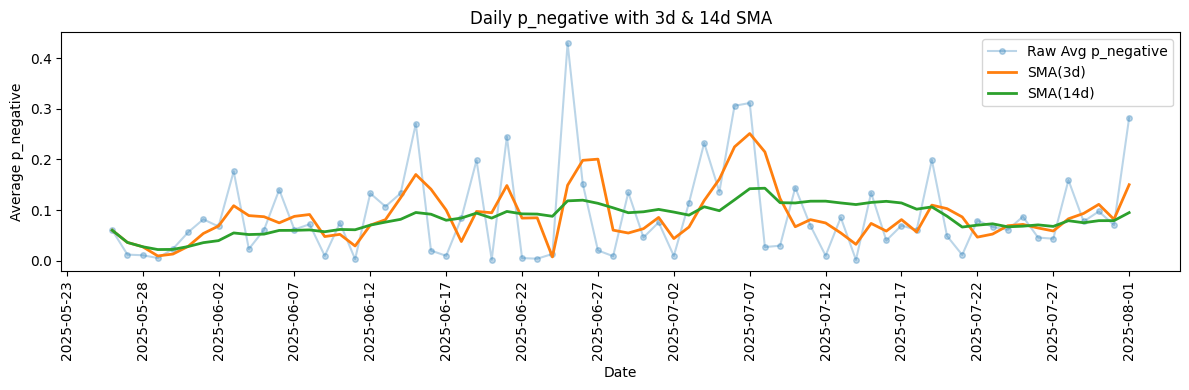

In [236]:
# 1) Ресемплинг по дням и вычисление среднего p_negative
ts = (
    df
    .set_index('date')['p_negative']
    .resample('D')
    .mean()  # NaN в дни без отзывов
    .reset_index(name='avg_p_negative')
)

# 2) Скользящие средние 3‑дневная и 14‑дневная
ts['sma3']  = ts['avg_p_negative'].rolling(window=3,  min_periods=1).mean()
ts['sma14'] = ts['avg_p_negative'].rolling(window=14, min_periods=1).mean()

# 3) Построение графика
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(ts['date'], ts['avg_p_negative'],
        marker='o', linestyle='-', markersize=4,
        alpha=0.3, label='Raw Avg p_negative')

ax.plot(ts['date'], ts['sma3'],
        linewidth=2, label='SMA(3d)')

ax.plot(ts['date'], ts['sma14'],
        linewidth=2, label='SMA(14d)')

# Тики по оси X: метки каждые 5 дней
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='x', rotation=90)  # вертикальные подписи

ax.set_title('Daily p_negative with 3d & 14d SMA')
ax.set_xlabel('Date')
ax.set_ylabel('Average p_negative')
ax.legend()

plt.tight_layout()
plt.show()


### Поиск аномалий во временных рядах

In [238]:
# 1) Объявляем новые отзывы за 2025-08-02
new_reviews = pd.DataFrame([
    {
        'date': pd.to_datetime('2025-08-02'),
        'rating': 1,
        'text': 'Наушники ужасные: звук прерывается, корпус уже через неделю развалился, не рекомендую.',
    },
    {
        'date': pd.to_datetime('2025-08-02'),
        'rating': 2,
        'text': 'Думал, будут нормальные наушники, но заряд держит очень мало — через полчаса разряжаются, и басов почти нет.',
    },
    {
        'date': pd.to_datetime('2025-08-02'),
        'rating': 5,
        'text': 'Крутные наушники, звук очень крутой.',
    }
])

# 2) Добавляем их в df
df3 = df.copy()
df3 = pd.concat([df3, new_reviews], ignore_index=True)

# 3) Проверка добавления
display(df3[df3['date'] == '2025-08-02'])


,text,rating,date,pred_label,p_positive,p_negative
931,"Наушники ужасные: звук прерывается, корпус уже через неделю развалился, не рекомендую.",1,2025-08-02,NaN,NaN,NaN
932,"Думал, будут нормальные наушники, но заряд держит очень мало — через полчаса разряжаются, и басов почти нет.",2,2025-08-02,NaN,NaN,NaN
933,"Крутные наушники, звук очень крутой.",5,2025-08-02,NaN,NaN,NaN


In [240]:
def check_negative_day_universal(
    check_date,
    df,
    neg_threshold=3,
    alpha=0.05,
    min_reviews=5,
    volume_ratio=0.3
):
    """
    Проверяет, является ли день `check_date` аномально негативным по биномиальному тесту,
    и если да, оценивает, достаточно ли объём отзывов.

    Параметры:
    -----------
    check_date : str или datetime-like
        Дата, например '2025-07-29'.
    df : pd.DataFrame
        ДатаFrame с колонками:
          - 'date'   (datetime64 или приводимая к нему)
          - 'rating' (int 1–5)
    neg_threshold : int
        Оценки ≤ neg_threshold считаются «плохими».
    alpha : float
        Уровень значимости для биномиального теста.
    min_reviews : int
        Ниже этого абсолютного числа отзывов за день — считается малым объёмом.
    volume_ratio : float
        Если число отзывов < volume_ratio * среднее число отзывов, тоже малый объём.

    Логика:
    1) Строим бинарный признак “is_bad” по порогу neg_threshold.
    2) Вычисляем фон p0 = средняя доля “плохих” до check_date.
    3) Считаем k/n за check_date, запускаем binomtest.
    4) Если p‑value < alpha → негативный день.
       Тогда считаем:
         avg_n = среднее число отзывов в день до check_date.
       И только если n < min_reviews **или** n < avg_n * volume_ratio,
       выводим дополнительно «Возможно, из‑за малого количества отзывов (n vs avg_n)».
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['is_bad'] = (df['rating'] <= neg_threshold).astype(int)

    d = pd.to_datetime(check_date).normalize()
    # фон
    df_before = df[df['date'] < d]
    if df_before.empty:
        print(f"Нет данных до {d.date()}, не могу определить фон.")
        return

    p0 = df_before['is_bad'].mean()
    avg_n = df_before.groupby('date').size().mean()

    # данные за сам день
    today = df[df['date'] == d]
    n = len(today)
    if n == 0:
        print(f"Нет отзывов за {d.date()}.")
        return

    k = int(today['is_bad'].sum())
    p_hat = k / n
    p_val = binomtest(k, n=n, p=p0, alternative='greater').pvalue

    if p_val < alpha:
        msg = (
            f"День {d.date()} считается негативным — "
            f"доля плохих оценок {p_hat:.1%} против обычной {p0:.1%} "
            f"(p‑value={p_val:.3f})."
        )
        # проверка объёма
        if n < min_reviews or n < avg_n * volume_ratio:
            msg += f" Возможно, связано с малым количеством отзывов ({n} vs средний {avg_n:.1f})."
        print(msg)
    else:
        print(
            f"День {d.date()} не считается негативным — "
            f"доля плохих оценок {p_hat:.1%} против обычной {p0:.1%} "
            f"(p‑value={p_val:.3f})"
        )

# Пример:
check_negative_day_universal("2025-06-25", df3)
check_negative_day_universal("2025-07-29", df3)
check_negative_day_universal("2025-08-02", df3)



День 2025-06-25 считается негативным — доля плохих оценок 42.9% против обычной 11.3% (p‑value=0.036).
День 2025-07-29 не считается негативным — доля плохих оценок 5.6% против обычной 11.4% (p‑value=0.887)
День 2025-08-02 считается негативным — доля плохих оценок 66.7% против обычной 11.3% (p‑value=0.035). Возможно, связано с малым количеством отзывов (3 vs средний 13.7).


In [333]:
import pandas as pd
import numpy as np
from scipy.stats import t

def detect_negative_drift(
    df,
    window: int = 7,
    end_date= pd.Timestamp.now().floor("D"),
    alpha: float = 0.05,
):
    """
    Простая проверка на drift по доле негатива: сравнивает текущее окно и предыдущее.
    Возвращает только строку с сообщением.
    Ожидает df с колонками 'date' и 'p_negative'.
    """
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"]).dt.floor("D")
    daily = (
        df.groupby("date")["p_negative"]
        .mean()
        .rename("avg_p_negative")
        .reset_index()
        .sort_values("date")
    )

    if len(daily) < 2 * window:
        return f"Недостаточно данных: нужно как минимум {2*window} дней, есть {len(daily)}."

    # Дополняем пропусками, чтобы окна были ровные
    full_idx = pd.date_range(daily["date"].min(), daily["date"].max(), freq="D")
    daily = daily.set_index("date").reindex(full_idx).rename_axis("date").reset_index()

    # Определяем конец текущего окна
    if end_date is None:
        curr_end = daily["date"].dropna().max()
    else:
        curr_end = pd.to_datetime(end_date).floor("D")
        if curr_end < daily["date"].min() or curr_end > daily["date"].max():
            return (
                f"end_date={curr_end.date()} вне доступного диапазона "
                f"{daily['date'].min().date()} - {daily['date'].max().date()}."
            )

    curr_start = curr_end - pd.Timedelta(days=window - 1)
    prev_end = curr_start - pd.Timedelta(days=1)
    prev_start = prev_end - pd.Timedelta(days=window - 1)

    if prev_start < daily["date"].min():
        return (
            f"Недостаточно предшествующих данных для предыдущего окна: "
            f"нужно {2*window} подряд дней до {curr_end.date()}."
        )

    curr_window = daily[
        (daily["date"] >= curr_start) & (daily["date"] <= curr_end)
    ].copy()
    prev_window = daily[
        (daily["date"] >= prev_start) & (daily["date"] <= prev_end)
    ].copy()

    if len(curr_window) < window or len(prev_window) < window:
        return (
            f"Окна неполные: требуются {window} дней в каждом, а есть "
            f"текущих {len(curr_window)}, предыдущих {len(prev_window)}."
        )

    if curr_window["avg_p_negative"].isna().any() or prev_window["avg_p_negative"].isna().any():
        return (
            "В окне есть пропуски по датам (пропущены значения), невозможно корректно оценить drift."
        )

    # Расчёт наклона (slope) текущего окна
    y = curr_window["avg_p_negative"].to_numpy()
    n = len(y)
    x = np.arange(n).astype(float)
    x_mean = x.mean()
    y_mean = y.mean()
    Sxx = np.sum((x - x_mean) ** 2)
    Sxy = np.sum((x - x_mean) * (y - y_mean))
    slope = Sxy / Sxx if Sxx != 0 else 0.0
    intercept = y_mean - slope * x_mean
    y_hat = intercept + slope * x
    residuals = y - y_hat
    rss = np.sum(residuals ** 2)
    mse = rss / (n - 2) if n - 2 > 0 else 0.0
    se_slope = np.sqrt(mse / Sxx) if Sxx != 0 and mse >= 0 else np.nan

    if se_slope and not np.isnan(se_slope) and se_slope > 0:
        t_stat = slope / se_slope
        dfree = n - 2
        p_one_sided = 1 - t.cdf(t_stat, dfree) if slope > 0 else 1.0
    else:
        p_one_sided = np.nan

    mean_prev = prev_window["avg_p_negative"].mean()
    mean_curr = curr_window["avg_p_negative"].mean()
    if mean_prev != 0:
        pct_change = (mean_curr - mean_prev) / mean_prev * 100
        sign = "+" if pct_change >= 0 else "-"
    else:
        pct_change = float("inf")
        sign = "+"

    # Форматирование
    current_interval = f"c {curr_start.date()} по {curr_end.date()}"
    slope_str = f"{slope:.4f}"
    p_str = f"{p_one_sided:.3f}" if not np.isnan(p_one_sided) else "n/a"
    mean_curr_str = f"{mean_curr:.3f}"
    pct_str = f"{sign}{abs(pct_change):.1f}%"

    drift_detected = (slope > 0) and (not np.isnan(p_one_sided)) and (p_one_sided < alpha)

    if drift_detected:
        message = (
            f"Drift выявлен в интервале {current_interval}, наклон={slope_str} (p={p_str}), "
            f"среднее в окне={mean_curr_str} vs предыдущее окно ({pct_str})."
        )
    else:
        message = (
            f"Drift не выявлен в интервале {current_interval}, наклон={slope_str} (p={p_str}), "
            f"среднее в окне={mean_curr_str} vs предыдущее окно ({pct_str})."
        )

    return message


In [334]:
print(detect_negative_drift(df, window=7))
print(detect_negative_drift(df, window=7, end_date="2025-07-07"))


Drift не выявлен в интервале c 2025-07-26 по 2025-08-01, наклон=0.0251 (p=0.062), среднее в окне=0.111 vs предыдущее окно (+40.1%).
Drift выявлен в интервале c 2025-07-01 по 2025-07-07, наклон=0.0472 (p=0.005), среднее в окне=0.169 vs предыдущее окно (+47.2%).


### Кластеризация негатива в отзывах

Для разбивки предложения использую spacy

In [241]:
df_neg = df[df['p_negative'] >= 0.3]

NameError: name 'df' is not defined

In [ ]:
import spacy
from sentence_transformers import SentenceTransformer
import hdbscan
from collections import defaultdict, Counter
import warnings

# 1) Загружаем модель spaCy (разово)
nlp = spacy.load("ru_core_news_sm")

# 2) Функция для разбивки текста на предложения через spaCy
def split_spacy(text: str) -> list[str]:
    if not isinstance(text, str):
        return []
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

# 3) Предполагаем, что у вас уже есть df_neg:
#    df_neg = df[df['p_negative'] >= 0.3]

# 4) Применяем spaCy-сегментацию к каждому отзыву
df_neg['sents_spacy'] = df_neg['text'].apply(split_spacy)

# 5) Проверяем результат на первой строке
print(df_neg[['text', 'sents_spacy']].iloc[0])


NameError: name 'df_neg' is not defined

In [243]:
df_neg

,text,rating,date,pred_label,p_positive,p_negative,sents_spacy
1,Деньги на ветер. Не че не понравилось. В фотографиях другие совсем нашники а отправили вообще другие наушники порванная упаковка,1,2025-08-01,negative,0.000431,0.984855,"[Деньги на ветер., Не че не понравилось., В фотографиях другие совсем нашники а отправили вообще другие наушники порванная упаковка]"
4,Не держат заряд \nДеньги на ветер...,1,2025-08-01,neutral,0.028226,0.421542,[Не держат заряд \nДеньги на ветер...]
14,"🫶🏻. Звук хороший и чистый , надеюсь не будет логать и прослужит долго .. На корпусе пятно непонятного характера , видимо брак ! Для этого наверное отправили в подарок чехол ,что бы скрыть деффнкт корпуса .",5,2025-07-31,negative,0.001753,0.708705,"[🫶🏻. Звук хороший и чистый , надеюсь не будет логать и прослужит долго .., На корпусе пятно непонятного характера , видимо брак !, Для этого наверное отправили в подарок чехол ,что бы скрыть деффнкт корпуса .]"
18,Брак наушник. Сегодня получил наушник брак,1,2025-07-30,negative,0.001128,0.858502,"[Брак наушник., Сегодня получил наушник брак]"
33,Ничего. Не работают,1,2025-07-30,negative,0.002270,0.847444,"[Ничего., Не работают]"
47,"Не могу нарадоваться звуком, который пронизывает до мурашек",5,2025-07-29,neutral,0.006344,0.452021,"[Не могу нарадоваться звуком, который пронизывает до мурашек]"
52,Звук отвратный,1,2025-07-29,negative,0.002195,0.835644,[Звук отвратный]
60,"Оно и ожидалось за свои деньги.. Плохой звук,динамик внутри наушника хрипит",1,2025-07-28,neutral,0.006923,0.344784,"[Оно и ожидалось за свои деньги.., Плохой звук,динамик внутри наушника хрипит]"
63,"не подключаюся к телефону , очень огорчена",3,2025-07-28,negative,0.001080,0.824145,"[не подключаюся к телефону ,, очень огорчена]"
67,"В наушниках невозможно слушать музыку, постоянно ставят на паузу. Можно оформить возврат?",3,2025-07-28,negative,0.000675,0.952446,"[В наушниках невозможно слушать музыку, постоянно ставят на паузу., Можно оформить возврат?]"


In [248]:

# предполагаем, что у вас уже есть столбец sents_spacy с сегментами
sents = [sent 
         for subs in df_neg['sents_spacy'] 
         for sent in subs
         if len(sent.split()) >= 2 # фильтр слишком коротких фрагментов
        ]

# 2) Кодируем каждое предложение в dense-эмбеддинг
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
embeddings = model.encode(sents, show_progress_bar=True)

# 3) Кластеризуем через HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=4,        # минимум 3 фраз в кластере
    metric="euclidean",        
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(embeddings)

# 4) Собираем и выводим примеры из каждого кластера
clusters = defaultdict(list)
for lbl, sent in zip(labels, sents):
    clusters[lbl].append(sent)

for lbl, examples in clusters.items():
    if lbl == -1:
        continue   # «шумовые» фразы пропускаем
    print(f"\n=== Cluster {lbl} (n={len(examples)}) ===")
    for ex in examples[:5]:
        print(" •", ex)


Batches: 100%|██████████| 6/6 [00:00<00:00, 16.69it/s]


=== Cluster 1 (n=28) ===
 • Брак наушник.
 • Плохой звук,динамик внутри наушника хрипит
 • через два дня использования начались проблемы с зарядкой,каждый раз показывает разный заряд,достаю один наушник- у кейса 60,а у наушников по 50-60,достаю второй наушник- уже абсолютно другой процентаж,а если достаю два,то показывает,что один из наушников разряжен,так же не заряжаются
 • Не работает левый наушник, я разочарована
 • разряжается за 30 минут полностью, правый наушник сразу начал хрипеть, наушники забрал 2 дня назад, не ронял, не ломал, продавец, отпишитесь пожалуйста

=== Cluster 0 (n=7) ===
 • очень огорчена
 • А без этого пакета естественно меня никто на пункте выдачи не примет !
 • не суветую их брать.
 • Перетсали заряжятся после пару доей использования
 • Плюс то что они есть )).


In [249]:
# 0) Отключаем FutureWarning от sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# (1) После того как у вас уже есть список `sents` и массив `labels`,
#     посчитаем сколько элементов в каждом кластере:
counts = Counter(labels)
print("Размеры кластеров (label: count):")
for lbl, cnt in counts.most_common():
    print(f"  {lbl:>3}: {cnt}")

# (2) Выведем несколько примеров из «больших» кластеров:
for lbl, cnt in counts.items():
    if lbl == -1 or cnt < 8:
        # шум или слишком мелкий кластер
        continue
    print(f"\n=== Cluster {lbl} (n={cnt}) ===")
    # покажем до 5 предложений из этого кластера
    examples = [s for s, L in zip(sents, labels) if L == lbl]
    for ex in examples[:20]:
        print(" •", ex)


Размеры кластеров (label: count):
   -1: 146
    1: 28
    0: 7

=== Cluster 1 (n=28) ===
 • Брак наушник.
 • Плохой звук,динамик внутри наушника хрипит
 • через два дня использования начались проблемы с зарядкой,каждый раз показывает разный заряд,достаю один наушник- у кейса 60,а у наушников по 50-60,достаю второй наушник- уже абсолютно другой процентаж,а если достаю два,то показывает,что один из наушников разряжен,так же не заряжаются
 • Не работает левый наушник, я разочарована
 • разряжается за 30 минут полностью, правый наушник сразу начал хрипеть, наушники забрал 2 дня назад, не ронял, не ломал, продавец, отпишитесь пожалуйста
 • Сразу при получении попытался поменять амбушуры на поменьше
Во-первых, амбушуры вообще не держались в своей упаковке, выпали
Во-вторых, две амбушуры вообще не для этих наушников, а для обычных
В-третьих на правом наушнике сразу снялась амбушура, на левом же пришлось постараться чтобы ек снять, да так что вообще развалился наушник и оторвались провода…
 •